In [1]:


import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from scipy.stats import mannwhitneyu
import plotly.figure_factory as ff
from scipy.stats import gaussian_kde

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
        fbeta_score,
        make_scorer,
        accuracy_score,
        roc_auc_score,
        precision_score,
        recall_score,
        average_precision_score,
        f1_score,
        confusion_matrix,
        classification_report,
        ConfusionMatrixDisplay,
    )
from sklearn.base import clone

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st
import shap
from dash import Dash, dcc, html, Input, Output



In [3]:
df = pd.read_csv('kaggle/input/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [5]:
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

# Data Cleaning

In [8]:
customerIDs = df[['customerID']].values

In [10]:
print(customerIDs)

[['7590-VHVEG']
 ['5575-GNVDE']
 ['3668-QPYBK']
 ...
 ['4801-JZAZL']
 ['8361-LTMKD']
 ['3186-AJIEK']]


In [12]:
df.drop(['customerID'], axis=1, inplace=True)

In [14]:
df.shape

(7043, 20)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [18]:
df.SeniorCitizen.value_counts()

SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64

For some reason sensior citizen is noted as 0 or 1 instead of yes or no unlike the other metrics so for the exploration ill be changing this to yes or no for now

In [21]:
binary_map = {0 : 'No', 1 : 'Yes'}
df['SeniorCitizen'] = df['SeniorCitizen'].map(binary_map)

In [23]:
df.columns.values

array(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

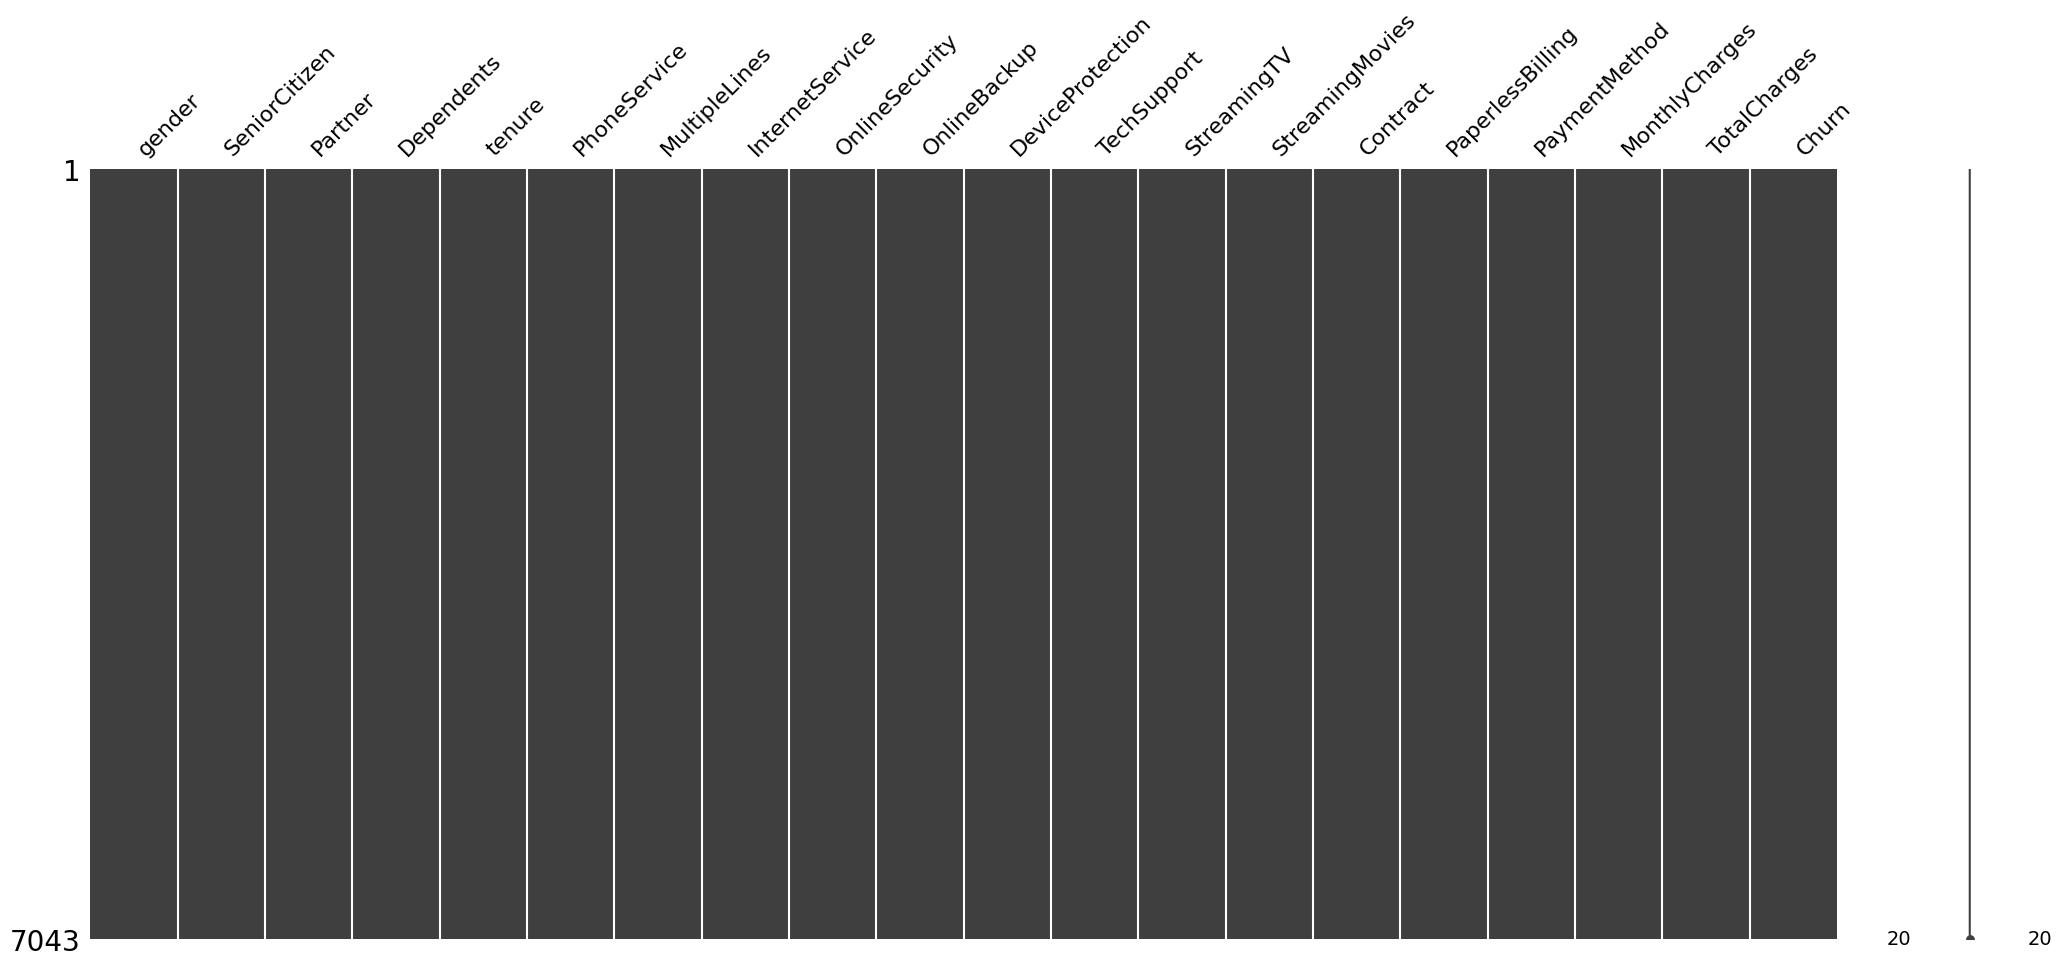

In [25]:
msno.matrix(df);

Using MissingNo we can form a matrix to see any missing values, but there doesnt seems to be any, lets dive deeper

In [28]:
df.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [30]:
df.dtypes

gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

When looking through the data types for some reason TotalCharges is an object column instead of a float which seems suspicious so lets look into that

In [33]:
df.TotalCharges.value_counts()

TotalCharges
          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: count, Length: 6531, dtype: int64

We can see 11 values that are showed as ' ' which should be treated null or 0 lets find if we can see why this is the case by turning total charges into a float column

In [36]:
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan, regex=True)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

In [38]:
df.loc[df['TotalCharges'].isna(), ['TotalCharges', 'tenure', 'MonthlyCharges']].head(10)


TotalCharges  tenure  MonthlyCharges
488            NaN       0           52.55
753            NaN       0           20.25
936            NaN       0           80.85
1082           NaN       0           25.75
1340           NaN       0           56.05
3331           NaN       0           19.85
3826           NaN       0           25.35
4380           NaN       0           20.00
5218           NaN       0           19.70
6670           NaN       0           73.35

We can see that when tenure is 0 Total Charges will always be null this makes sense as no billing period has yet occured as tenure is the number of months they have been there so it would be appropriate to set Nan TotalCharges to 0

In [41]:
df.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [43]:
df.loc[df['tenure'] == 0, 'TotalCharges'] = 0

In [45]:
df.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

<Axes: >

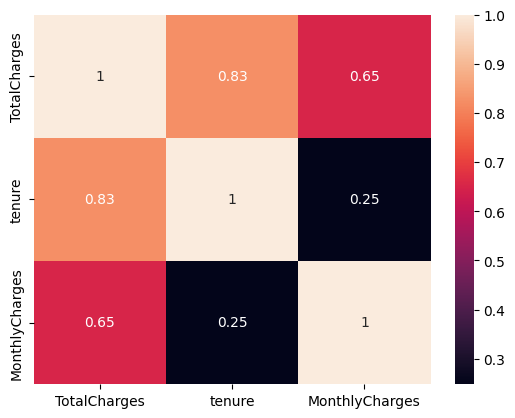

In [47]:
sns.heatmap(df[['TotalCharges', 'tenure', 'MonthlyCharges']].corr(),annot=True)

Ok now that the dataset is cleaned up a bit lets now explore the data

# Data Exploration

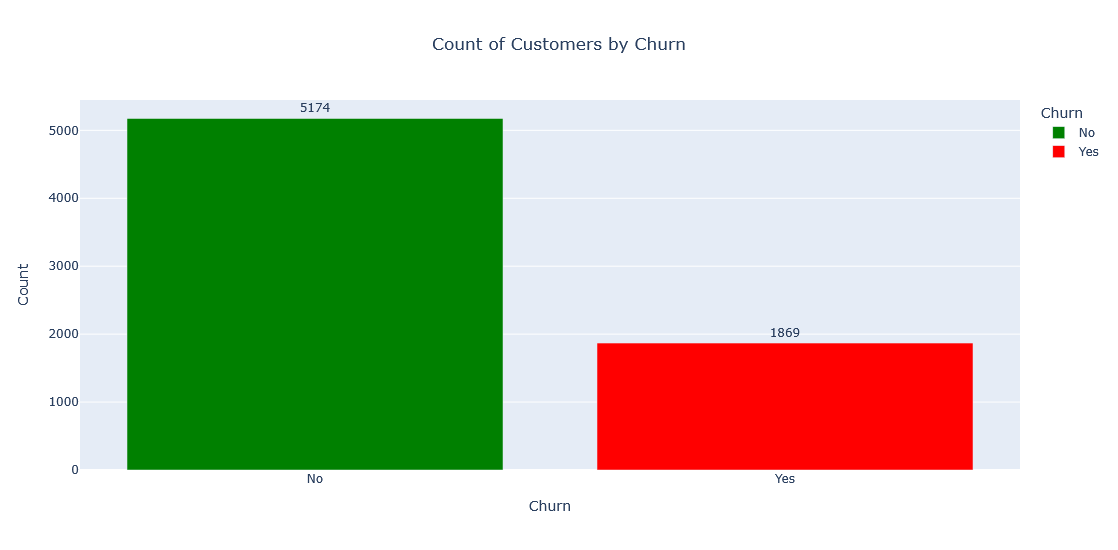

In [51]:
# Here we will plot the customer churn to see what we are dealing with
count_df = df['Churn'].value_counts().reset_index()
count_df.columns = ['Churn', 'Count']

colour_map = {
    'No': 'green',
    'Yes': 'red'
}

# Plot
fig = px.bar(
    count_df,
    x='Churn',
    y='Count',
    text='Count',
    title='Count of Customers by Churn',
    color='Churn',
    color_discrete_map=colour_map
)

# Formatting to match seaborn style
fig.update_traces(textposition='outside')
fig.update_layout(
    height=550,
    width=500,
    title_x=0.5
)

fig.show()

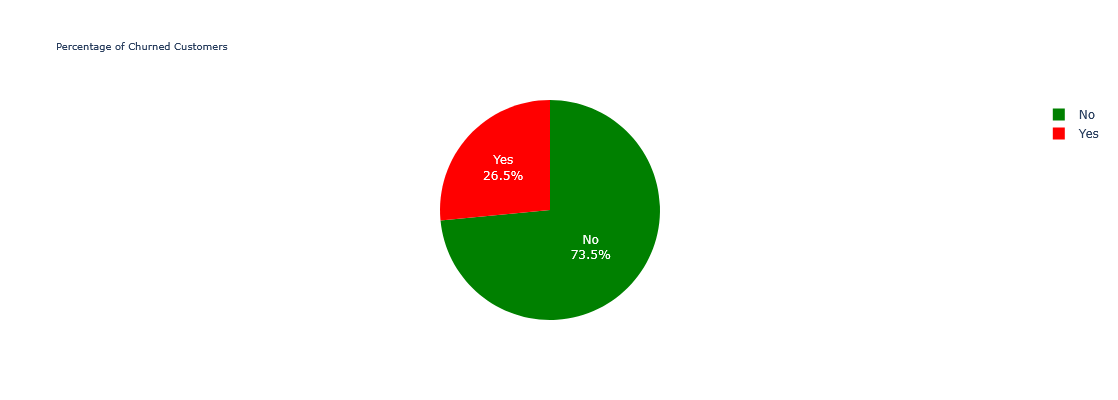

In [53]:
gb = df.groupby("Churn").size().reset_index(name='Count')

fig = px.pie(
    gb,
    values='Count',
    names='Churn',
    title='Percentage of Churned Customers',
    color='Churn',
    color_discrete_map=colour_map
)

fig.update_traces(textinfo='percent+label')
fig.update_layout(
    height=400,
    width=300,
    title_font_size=10
)

fig.show()

We can see that 26.5% of customers have churned out, lets now explore why this could be happening

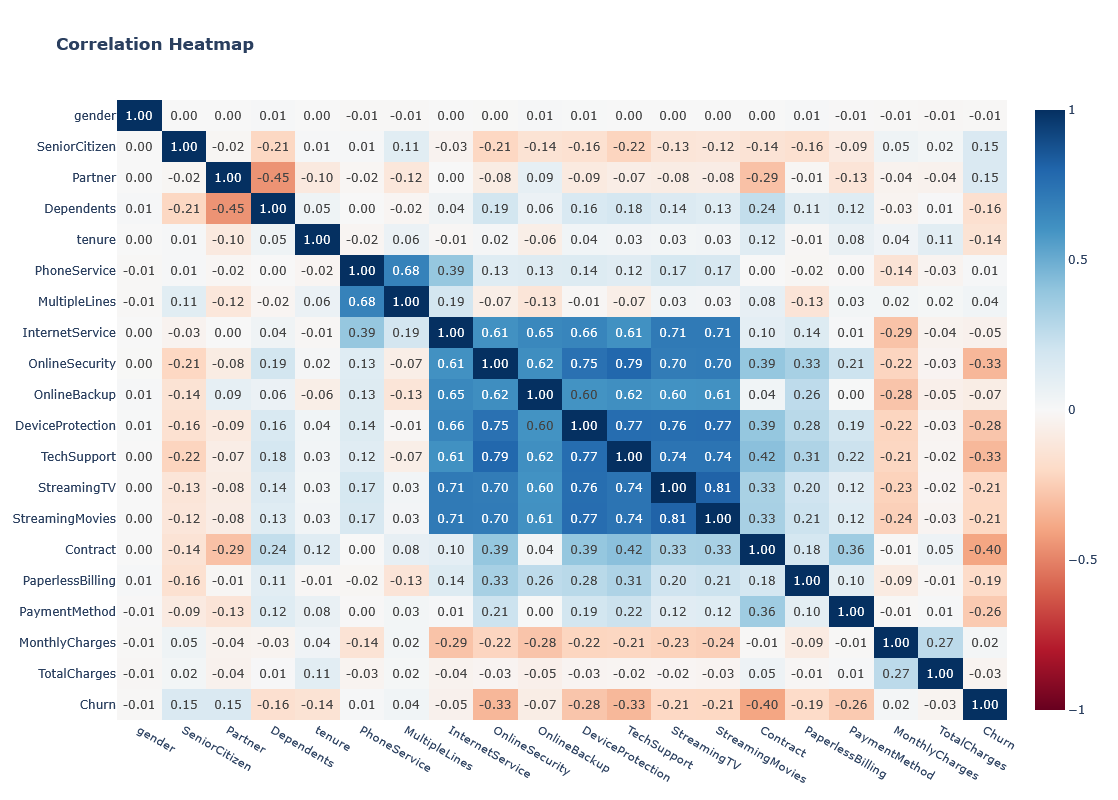

In [56]:
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()

# Plot heatmap
fig = px.imshow(
    corr,
    text_auto=".2f",
    aspect="auto",
    color_continuous_scale='RdBu',
    zmin=-1,
    zmax=1,
    title="<b>Correlation Heatmap</b>"
)

fig.update_layout(
    width=1000,
    height=800
)

fig.show()

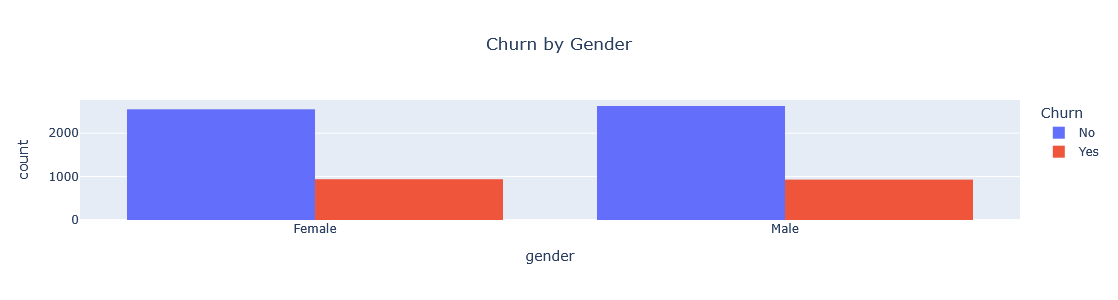

In [58]:
fig = px.histogram(
    df,
    x='gender',
    color='Churn',
    barmode='group',
    title='Churn by Gender'
)

fig.update_layout(
    height=300,
    width=300,
    title_x=0.5
)

fig.show()

There is a negligable difference between genders when it comes to customer churn, both genders behaved in a similair fashion when it comes to churning

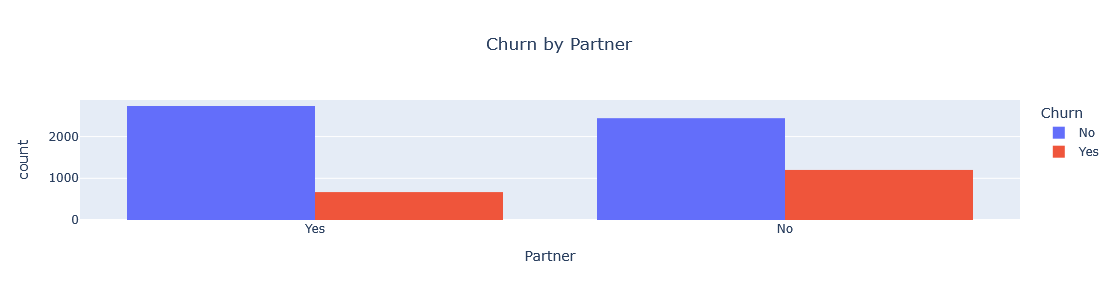

In [61]:
fig = px.histogram(
    df,
    x='Partner',
    color='Churn',
    barmode='group',
    title='Churn by Partner'
)

fig.update_layout(
    height=300,
    width=300,
    title_x=0.5
)

fig.show()

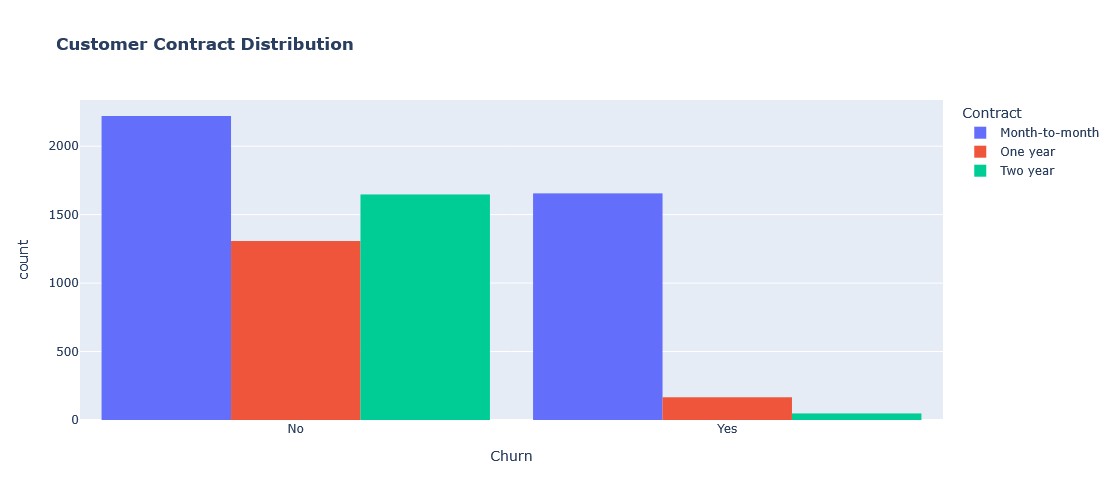

In [63]:
fig = px.histogram(
    df,
    x="Churn",
    color="Contract",
    barmode="group",
    title="<b>Customer Contract Distribution</b>"
)

fig.update_layout(
    width=700,
    height=500,
    bargap=0.1
)

fig.show()

We can see a majority of the customers who churned had month to month contracts over customers who had one or multi year contracts

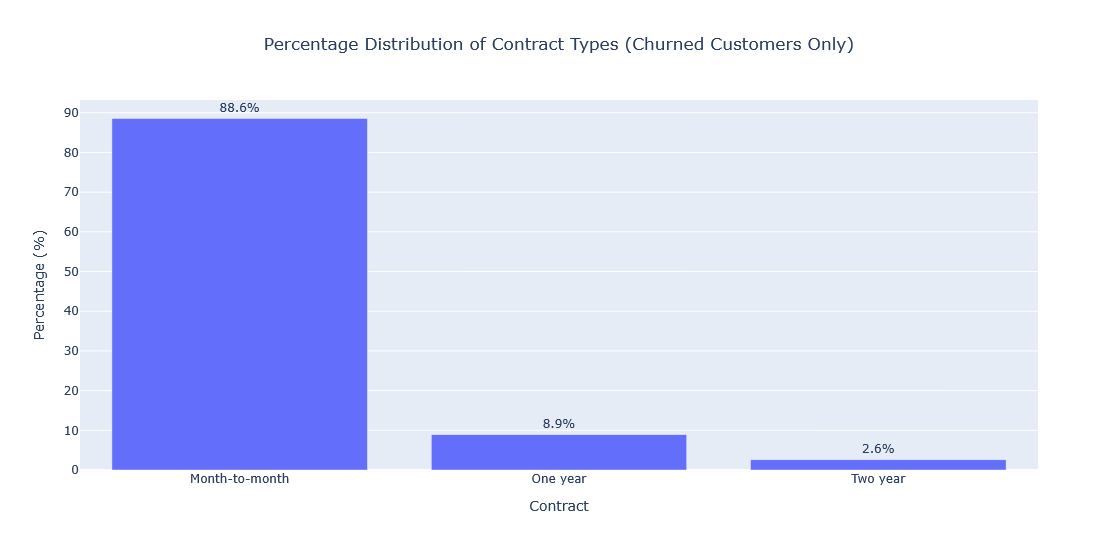

In [66]:
churned_df = df[df['Churn'].isin([1, 'Yes'])]

contract_percentages = (
    churned_df['Contract']
    .value_counts(normalize=True)
    .mul(100)
    .reset_index()
)

contract_percentages.columns = ['Contract', 'Percentage']

fig = px.bar(
    contract_percentages,
    x='Contract',
    y='Percentage',
    text='Percentage',
    title='Percentage Distribution of Contract Types (Churned Customers Only)'
)

fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_layout(
    width=700,
    height=550,
    yaxis_title='Percentage (%)',
    xaxis_title='Contract',
    title_x=0.5
)

fig.show()

Looking further we can see that 88.6% of customers who churned had a month to month contract

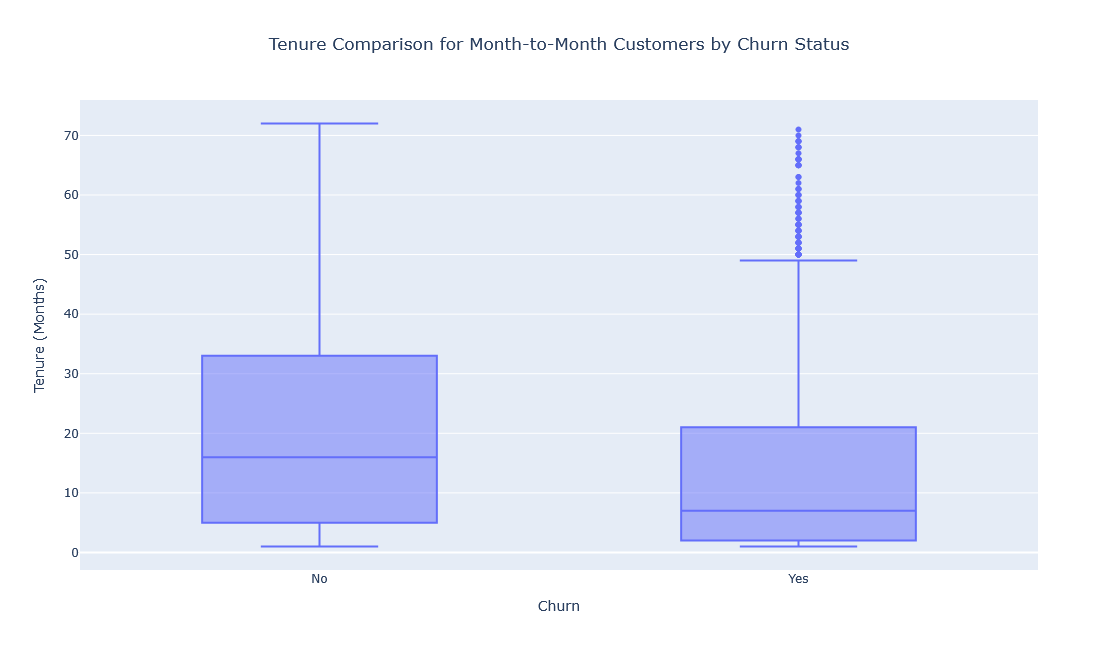

In [69]:
mtm_df = df[df['Contract'] == 'Month-to-month']

fig = px.box(
    mtm_df,
    x='Churn',
    y='tenure',
    title='Tenure Comparison for Month-to-Month Customers by Churn Status'
)

fig.update_layout(
    width=600,
    height=650,
    xaxis_title='Churn',
    yaxis_title='Tenure (Months)',
    title_x=0.5
)

fig.show()

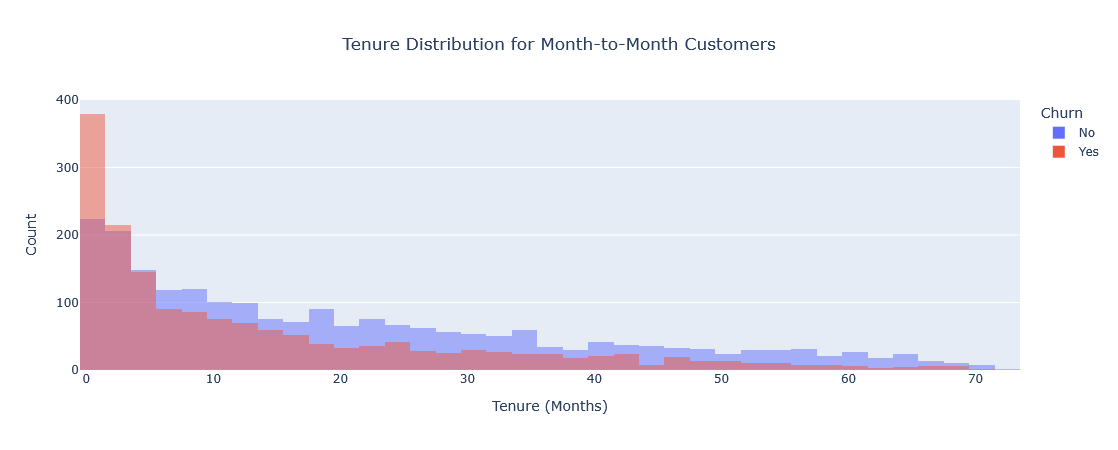

In [71]:
fig = px.histogram(
    mtm_df,
    x='tenure',
    color='Churn',
    barmode='overlay',
    title='Tenure Distribution for Month-to-Month Customers'
)

fig.update_layout(
    width=600,
    height=450,
    xaxis_title='Tenure (Months)',
    yaxis_title='Count',
    title_x=0.5
)

fig.show()

Among Month-to-Month customers, those who churned consistently show a noticeably shorter average tenure than those who remained. This suggests that early-stage customers on flexible contracts are significantly more vulnerable to churn. To help verify this we run a Mann-Whitney U test, The Mann–Whitney U test is a suitable choice here because it allows us to compare two independent groups without assuming the data follows a normal distribution. Since customer tenure is naturally skewed, this test provides a reliable way to confirm that the difference we are seeing between churned and non-churned customers is genuine and not due to chance.

In [74]:
mtm_df = df[df['Contract'] == 'Month-to-month']
mtm_churned = pd.to_numeric(
    mtm_df[mtm_df['Churn'].isin([1, 'Yes'])]['tenure'],
    errors='coerce'
).dropna()

mtm_not_churned = pd.to_numeric(
    mtm_df[mtm_df['Churn'].isin([0, 'No'])]['tenure'],
    errors='coerce'
).dropna()

u_stat, p_value = mannwhitneyu(
    mtm_churned,
    mtm_not_churned,
    alternative='two-sided'
)

u_stat, p_value
print(p_value)
if p_value < 0.05:
    print("Statistically significant difference in tenure between churned and non-churned Month-to-Month customers.")
else:
    print("No statistically significant difference in tenure between the two groups.")

mtm_churned = None
mtm_not_churned = None

2.9155505698490766e-43
Statistically significant difference in tenure between churned and non-churned Month-to-Month customers.


A Mann–Whitney U test was conducted to compare tenure between churned and non-churned Month-to-Month customers. The results show a highly statistically significant difference between the two groups (p = 2.92 × 10⁻⁴³), with churned customers exhibiting substantially shorter tenure. This confirms from the earlier graphs that customers on Month-to-Month contracts are particularly vulnerable to early churn

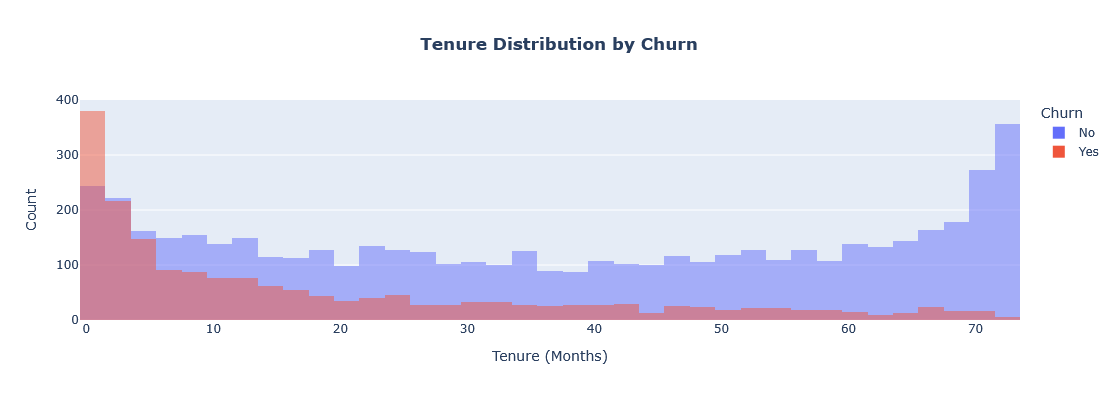

In [77]:
fig = px.histogram(
    df,
    x='tenure',
    color='Churn',
    nbins=72,
    title='<b>Tenure Distribution by Churn</b>',
    barmode='overlay'
)

fig.update_layout(
    width=900,
    height=400,
    xaxis_title='Tenure (Months)',
    yaxis_title='Count',
    title_x=0.5
)

fig.show()

Customers who go on to churn tend to leave very early in their time with the company, with the highest number of churners clustered in the first few months. As tenure increases, the number of customers who churn drops sharply. In contrast, customers who do not churn are spread across all tenure lengths, with many staying for several years. This reinforces the idea that the early stages of a customer’s journey are the most critical period for retention.

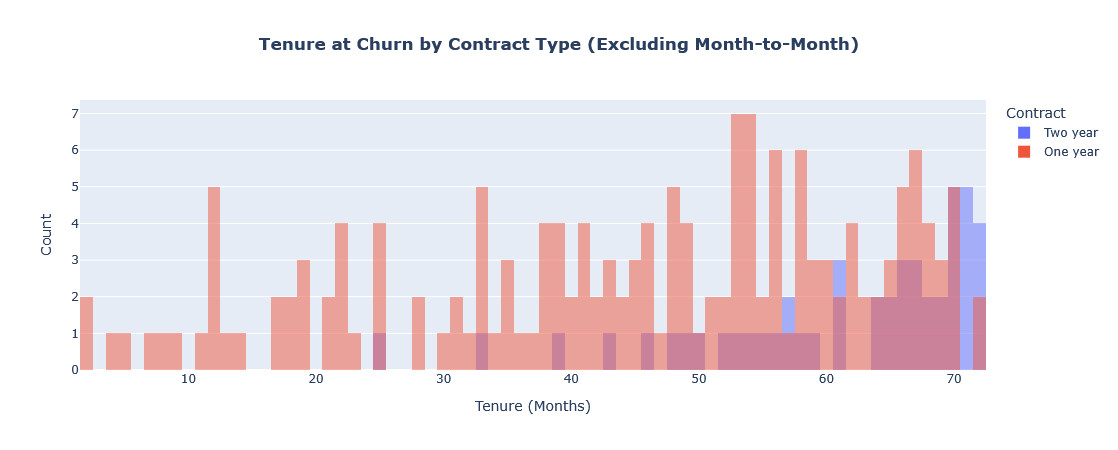

In [80]:
churned_contract_df = df[
    (df['Churn'].isin([1, 'Yes'])) &
    (df['Contract'] != 'Month-to-month')
]

fig = px.histogram(
    churned_contract_df,
    x='tenure',
    color='Contract',
    nbins=72,
    barmode='overlay',
    title='<b>Tenure at Churn by Contract Type (Excluding Month-to-Month)</b>'
)

fig.update_layout(
    width=900,
    height=450,
    xaxis_title='Tenure (Months)',
    yaxis_title='Count',
    title_x=0.5
)

fig.show()

Once Month-to-Month customers are removed, churn among One-Year and Two-Year contract customers tends to happen much later in their time with the company. Customers on One-Year contracts appear to churn across a wide range of tenures, particularly between around 30 and 60 months. In contrast, Two-Year contract churn is much less frequent and is mainly concentrated at very high tenure values, close to the end of the contract cycle. This shows that longer contracts are generally more stable, with customers tending to remain for many years before leaving

When this is compared with Month-to-Month customers, a clear difference emerges. Month-to-Month customers tend to make up their minds very early about whether they want to stay, with most churn happening in the first part of their customer journey. In contrast, customers on One-Year and Two-Year contracts tend to leave much later, often after many years with the company. This suggests that churn among longer-term contract customers is less about early dissatisfaction and more likely to be driven by changes over time, such as shifts in pricing, service quality, customer needs, or company policies, which may influence their decision to leave once their contract period is coming to an end.

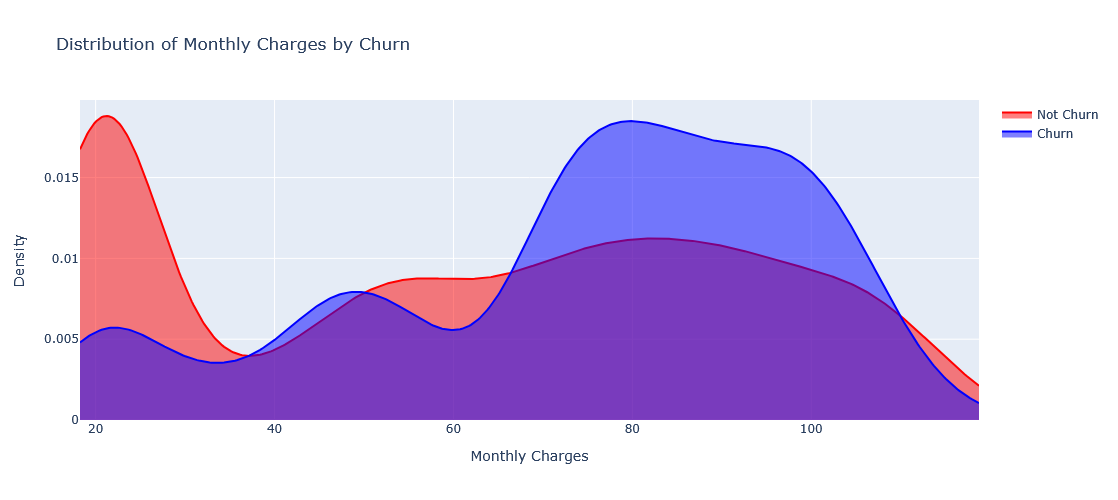

In [83]:
x_no  = df.loc[df['Churn'] == 'No',  'MonthlyCharges']
x_yes = df.loc[df['Churn'] == 'Yes', 'MonthlyCharges']

# Create KDE functions
kde_no = gaussian_kde(x_no)
kde_yes = gaussian_kde(x_yes)

# X range for smooth curves
x_range = np.linspace(df['MonthlyCharges'].min(), df['MonthlyCharges'].max(), 500)

y_no = kde_no(x_range)
y_yes = kde_yes(x_range)

# Plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x_range,
    y=y_no,
    fill='tozeroy',
    name='Not Churn',
    line=dict(color='red')
))

fig.add_trace(go.Scatter(
    x=x_range,
    y=y_yes,
    fill='tozeroy',
    name='Churn',
    line=dict(color='blue')
))

fig.update_layout(
    title='Distribution of Monthly Charges by Churn',
    xaxis_title='Monthly Charges',
    yaxis_title='Density',
    width=850,
    height=500
)

fig.show()

Customers with higher monthly charges are noticeably more likely to churn. The distribution shows that churn is much more concentrated at the upper end of monthly pricing, whereas customers on lower monthly charges are more likely to remain with the service. This suggests that cost may be an important factor influencing a customer’s decision to leave.

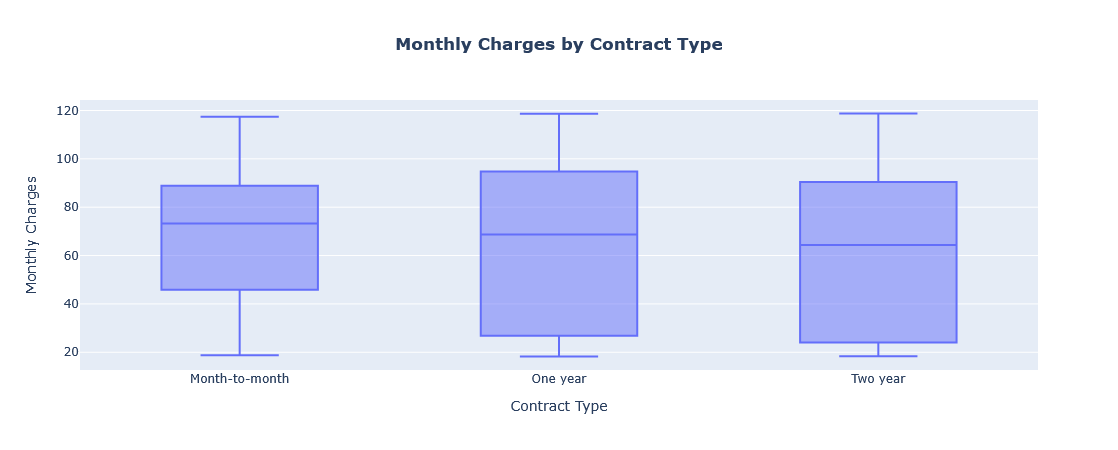

In [86]:
fig = px.box(
    df,
    x='Contract',
    y='MonthlyCharges',
    title='<b>Monthly Charges by Contract Type</b>'
)

fig.update_layout(
    width=700,
    height=450,
    xaxis_title='Contract Type',
    yaxis_title='Monthly Charges',
    title_x=0.5
)

fig.show()

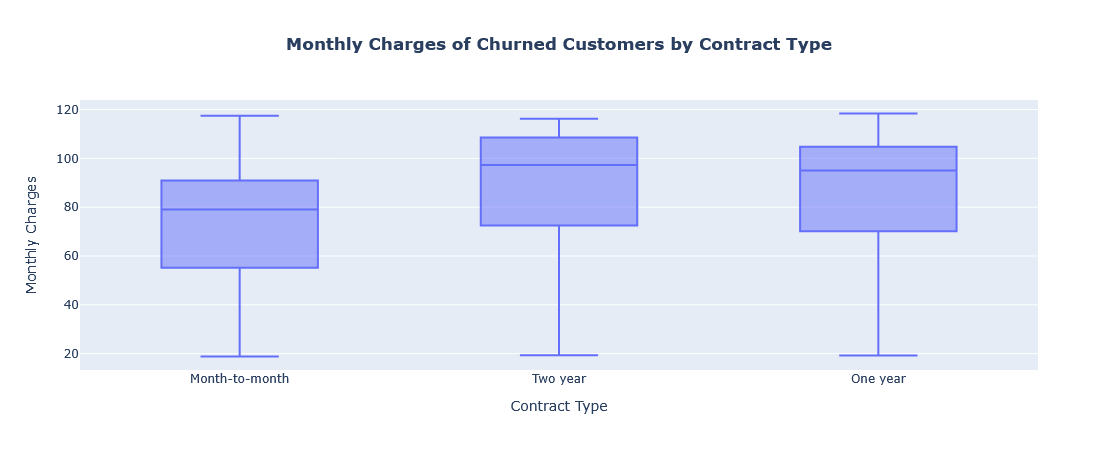

Contract Churn  MonthlyCharges
0  Month-to-month    No       61.462635
1  Month-to-month   Yes       73.019396
2        One year    No       62.508148
3        One year   Yes       85.050904
4        Two year    No       60.012477
5        Two year   Yes       86.777083

In [88]:
churned_df = df[df['Churn'].isin([1, 'Yes'])]

fig = px.box(
    churned_df,
    x='Contract',
    y='MonthlyCharges',
    title='<b>Monthly Charges of Churned Customers by Contract Type</b>'
)

fig.update_layout(
    width=700,
    height=450,
    xaxis_title='Contract Type',
    yaxis_title='Monthly Charges',
    title_x=0.5
)

fig.show()
price_summary = (
    df
    .groupby(['Contract', 'Churn'])['MonthlyCharges']
    .mean()
    .reset_index()
)

price_summary

In [90]:
price_summary = (
    df
    .groupby(['Contract', 'Churn'])['MonthlyCharges']
    .mean()
    .reset_index()
)

price_summary

Contract Churn  MonthlyCharges
0  Month-to-month    No       61.462635
1  Month-to-month   Yes       73.019396
2        One year    No       62.508148
3        One year   Yes       85.050904
4        Two year    No       60.012477
5        Two year   Yes       86.777083

Across all contract types, customers who churn consistently pay more per month than those who stay, showing a clear positive relationship between higher pricing and churn. This effect is especially strong for One-Year and Two-Year customers. Not only do churned long-term customers pay significantly more than retained long-term customers, but they also start from a much higher base price when they eventually leave. In other words, customers on longer contracts tend to tolerate higher prices for a long period of time, but when pricing is pushed too far, it becomes a clear trigger for them to leave. This suggests that while long-term contracts provide stability, aggressive pricing over time can ultimately erode loyalty and lead even committed customers to churn.

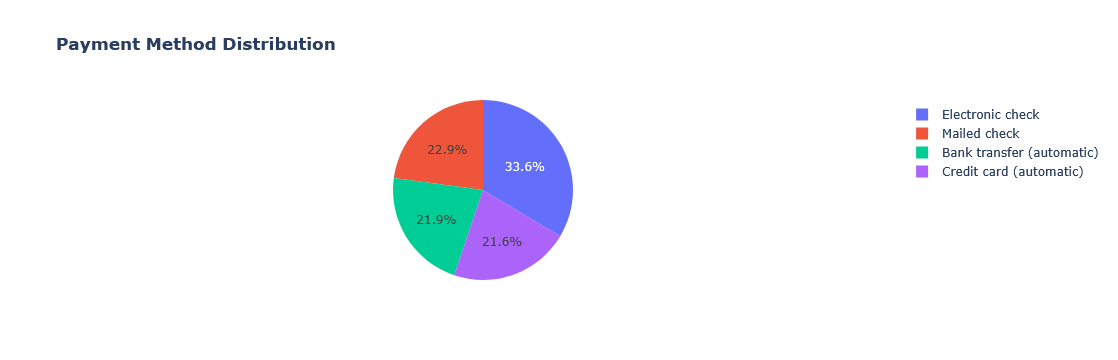

In [93]:

payment_counts = df['PaymentMethod'].value_counts().reset_index()
payment_counts.columns = ['PaymentMethod', 'Count']

fig = go.Figure(
    data=[go.Pie(
        labels=payment_counts['PaymentMethod'],
        values=payment_counts['Count']
    )]
)

fig.update_layout(title_text="<b>Payment Method Distribution</b>")
fig.show()

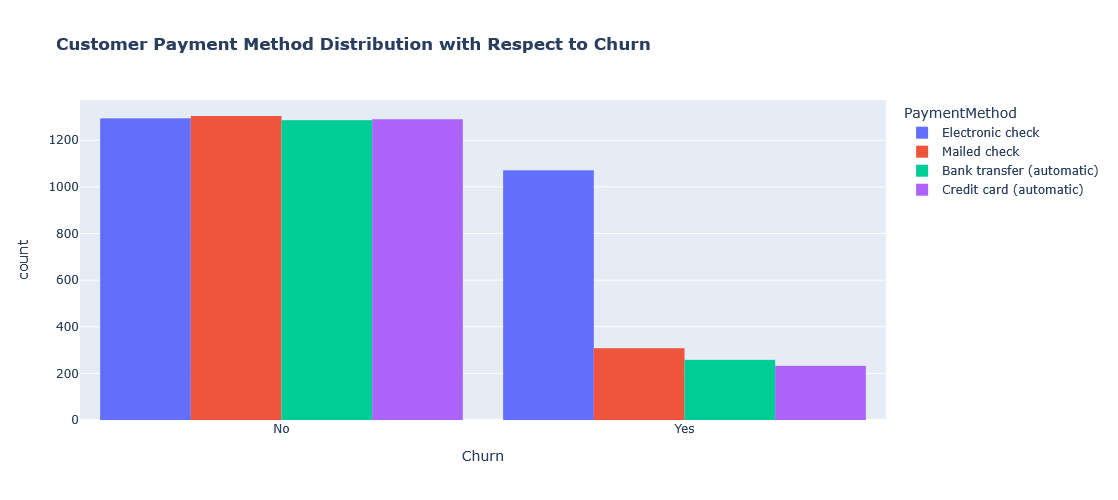

In [96]:
fig = px.histogram(
    df,
    x="Churn",
    color="PaymentMethod",
    barmode="group",
    title="<b>Customer Payment Method Distribution with Respect to Churn</b>"
)

fig.update_layout(
    width=700,
    height=500,
    bargap=0.1
)

fig.show()

We can see most customers who churned paid by Electronic Check. This could point to some issues with this payment method, but it doesn’t fully explain the pattern on its own. Mailed Check is also a manual payment method, yet its churn rate is similar to automatic methods like Bank Transfer and Credit Card. This suggests that the higher churn seen with Electronic Check is unlikely to be simply because it is not automated, and may instead be linked to other customer behaviours or characteristics.

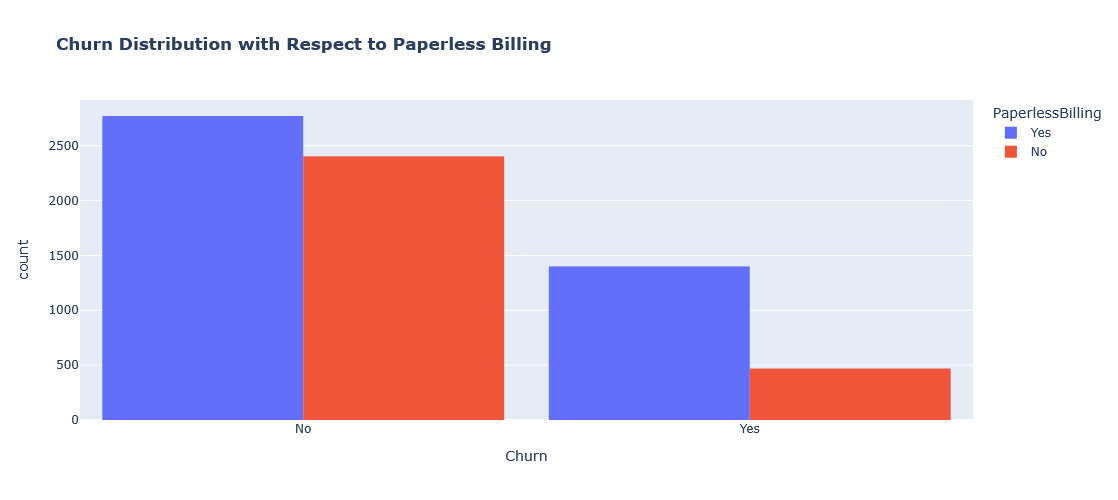

In [99]:


fig = px.histogram(
    df,
    x="Churn",
    color="PaperlessBilling",
    barmode="group",
    title="<b>Churn Distribution with Respect to Paperless Billing</b>"
)

fig.update_layout(
    width=700,
    height=500,
    bargap=0.1
)

fig.show()

In [101]:
pd.crosstab(
    df['PaymentMethod'],
    df['PaperlessBilling'],
    normalize='index'
).mul(100)

PaperlessBilling                  No        Yes
PaymentMethod                                  
Bank transfer (automatic)  42.292746  57.707254
Credit card (automatic)    42.049934  57.950066
Electronic check           26.342495  73.657505
Mailed check               59.305211  40.694789

In [103]:
billing_pct = (
    pd.crosstab(
        [df['PaymentMethod'], df['PaperlessBilling']],
        df['Churn'],
        normalize='index'
    )
    .mul(100)
    .reset_index()
)
billing_pct

Churn              PaymentMethod PaperlessBilling         No        Yes
0      Bank transfer (automatic)               No  88.973966  11.026034
1      Bank transfer (automatic)              Yes  79.124579  20.875421
2        Credit card (automatic)               No  90.000000  10.000000
3        Credit card (automatic)              Yes  80.952381  19.047619
4               Electronic check               No  67.255217  32.744783
5               Electronic check              Yes  50.229621  49.770379
6                   Mailed check               No  86.506276  13.493724
7                   Mailed check              Yes  72.713415  27.286585

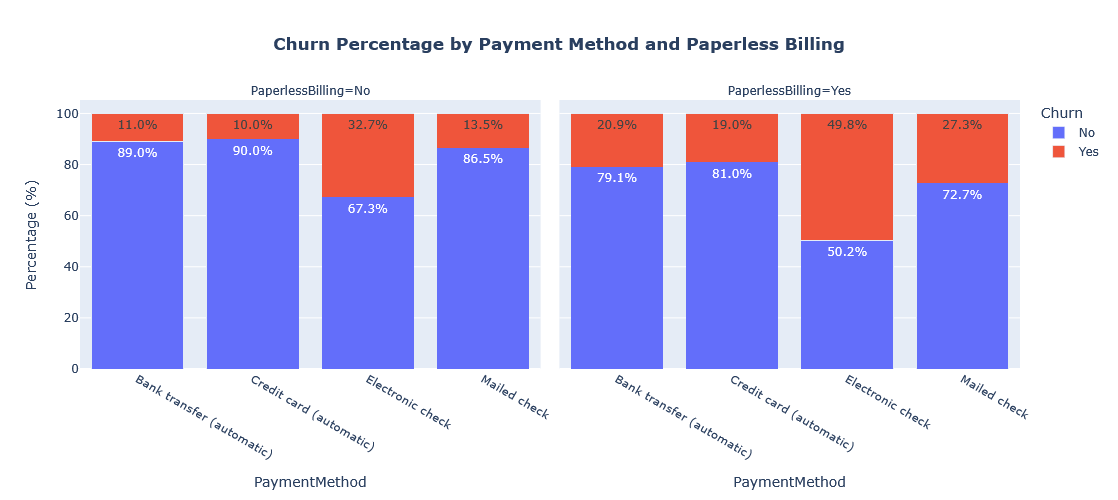

In [105]:
billing_pct = (
    pd.crosstab(
        [df['PaymentMethod'], df['PaperlessBilling']],
        df['Churn'],
        normalize='index'
    )
    .mul(100)
    .reset_index()
)

billing_pct = billing_pct.melt(
    id_vars=['PaymentMethod', 'PaperlessBilling'],
    var_name='Churn',
    value_name='Percentage'
)

fig = px.bar(
    billing_pct,
    x='PaymentMethod',
    y='Percentage',
    color='Churn',
    facet_col='PaperlessBilling',
    barmode='stack',
    text='Percentage',
    title='<b>Churn Percentage by Payment Method and Paperless Billing</b>'
)

fig.update_traces(texttemplate='%{text:.1f}%', textposition='inside')
fig.update_layout(
    width=1100,
    height=500,
    yaxis_title='Percentage (%)',
    title_x=0.5
)

fig.show()

The results demonstrate a clear behavioural relationship between payment method, adoption of paperless billing, and customer churn. Customers using automated payment methods (Bank Transfer and Credit Card) are moderately more likely to use paperless billing, with approximately 58% of these customers opting for paperless service. In contrast, Electronic Check users show the highest adoption of paperless billing (≈74%), while Mailed Check customers are predominantly paper-based, with only ≈41% using paperless billing. This confirms that paperless billing is closely linked to digital payment behaviour, rather than being evenly adopted across all customer groups.

When churn is examined within each payment and billing combination, important risk patterns emerge. Customers using automated payment methods without paperless billing exhibit the lowest churn rates, at approximately 10–11%, rising modestly to around 19–21% among those who also use paperless billing. This suggests that automated payments are inherently protective against churn, regardless of billing format.

In contrast, Electronic Check customers display the highest churn across both billing formats. Among those not using paperless billing, churn is already elevated at ≈33%, but for those using paperless billing, churn rises sharply to nearly 50%. This indicates that paperless billing does not act as a protective factor for Electronic Check users and instead highlights that this group represents a fundamentally higher-risk behavioural segment.

For Mailed Check customers, churn is moderate, increasing from ≈13% without paperless billing to ≈27% with paperless billing. This mirrors the pattern seen in Electronic Check users, albeit at a lower magnitude, and reinforces that manual payment methods consistently carry higher churn risk, regardless of whether billing is paper-based or paperless.

Collectively, these findings indicate that Paperless Billing does not independently reduce churn risk. Instead, it acts as a proxy for customer digital engagement and payment behaviour. Automated payment methods are strongly associated with stability and low churn, while manual payment methods—particularly Electronic Check—remain structurally high risk, even when customers adopt paperless billing. This suggests that the elevated churn observed among Electronic Check users is driven by deeper behavioural, financial, or service-fit factors rather than the billing format alone

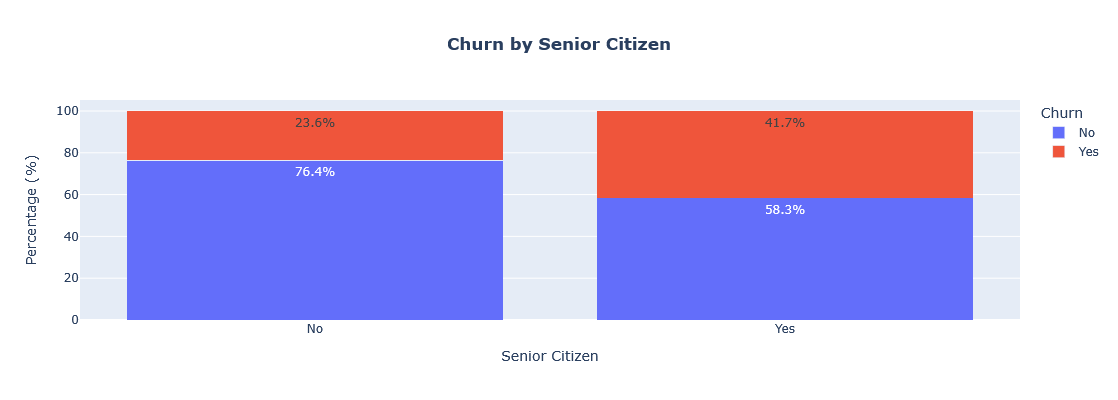

In [108]:
total_counts = (
    df
    .groupby('SeniorCitizen')['Churn']
    .value_counts(normalize=True)
    .mul(100)
    .rename('Percentage')
    .reset_index()
)

# Plot
fig = px.bar(
    total_counts,
    x='SeniorCitizen',
    y='Percentage',
    color='Churn',
    text='Percentage',
    barmode='stack',
    title='<b>Churn by Senior Citizen</b>'
)

# Formatting
fig.update_traces(texttemplate='%{text:.1f}%', textposition='inside')
fig.update_layout(
    width=700,
    height=400,
    xaxis_title='Senior Citizen',
    yaxis_title='Percentage (%)',
    legend_title='Churn',
    title_x=0.5
)

fig.show()

Most non-senior customers stay with the service around 76%, with only around a quarter choosing to leave whereas for senior citizens just over 41% left. This shows that senior customers are much more likely to leave than non-seniors, making age an important factor to consider when looking at customer retention in this dataset

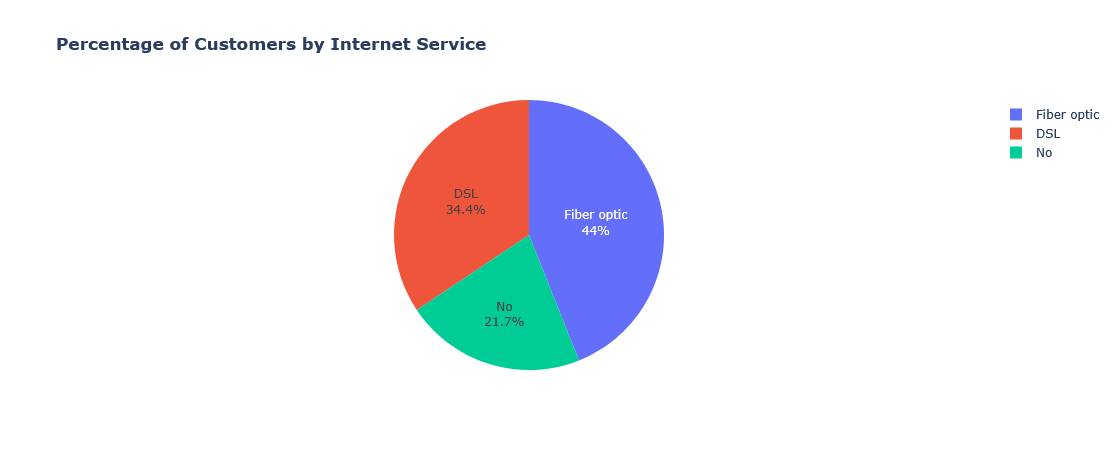

In [111]:
service_pct = (
    df['InternetService']
    .value_counts(normalize=True)
    .mul(100)
    .reset_index()
)

service_pct.columns = ['InternetService', 'Percentage']

# Plot
fig = go.Figure(
    data=[go.Pie(
        labels=service_pct['InternetService'],
        values=service_pct['Percentage'],
        textinfo='percent+label'
    )]
)

fig.update_layout(
    title_text='<b>Percentage of Customers by Internet Service</b>',
    width=600,
    height=450
)

fig.show()

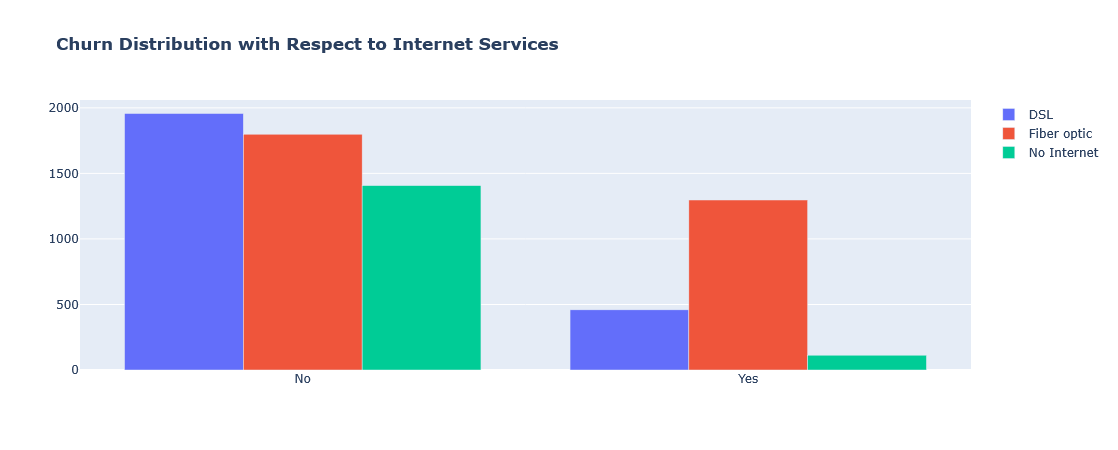

In [113]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=['No', 'Yes'],
    y=[965 + 992, 219 + 240],  # DSL totals (Female + Male)
    name='DSL'
))

fig.add_trace(go.Bar(
    x=['No', 'Yes'],
    y=[889 + 910, 664 + 633],  # Fiber optic totals
    name='Fiber optic'
))

fig.add_trace(go.Bar(
    x=['No', 'Yes'],
    y=[690 + 717, 56 + 57],  # No Internet totals
    name='No Internet'
))

fig.update_layout(
    title_text="<b>Churn Distribution with Respect to Internet Services</b>",
    barmode='group',
    width=700,
    height=450
)

fig.show()

A large proportion of customers use the Fibre Optic service, about 44%, and it is also clear that this group experiences the highest levels of churn. This may suggest a degree of dissatisfaction with this type of internet service. In comparison, customers using DSL make up a sizeable share of the customer base at 34% but show a lower churn rate than those on Fibre Optic, indicating that DSL users are generally more likely to remain with the service.

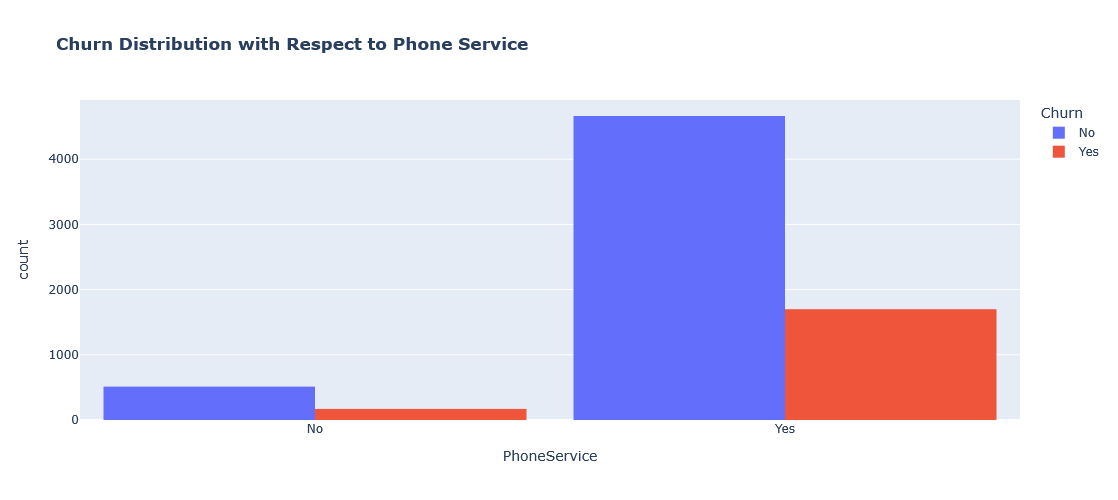

In [116]:
fig = px.histogram(
    df,
    x="PhoneService",
    color="Churn",
    barmode="group",
    title="<b>Churn Distribution with Respect to Phone Service</b>"
)

fig.update_layout(
    width=700,
    height=500,
    bargap=0.1
)

fig.show()


The majority of customers in the dataset have a phone service, and as a result, most churn also comes from this group. However, this does not necessarily mean that having a phone service causes customers to leave. Instead, it mainly reflects the fact that far more customers subscribe to a phone service than not. Customers without a phone service make up only a small proportion of the overall customer base and therefore contribute relatively little to total churn.

Overall, this suggests that phone service on its own is unlikely to be a strong driver of churn, and that other factors such as contract type, pricing, and length of time with the company are likely to play a much more important role in influencing whether a customer leaves.

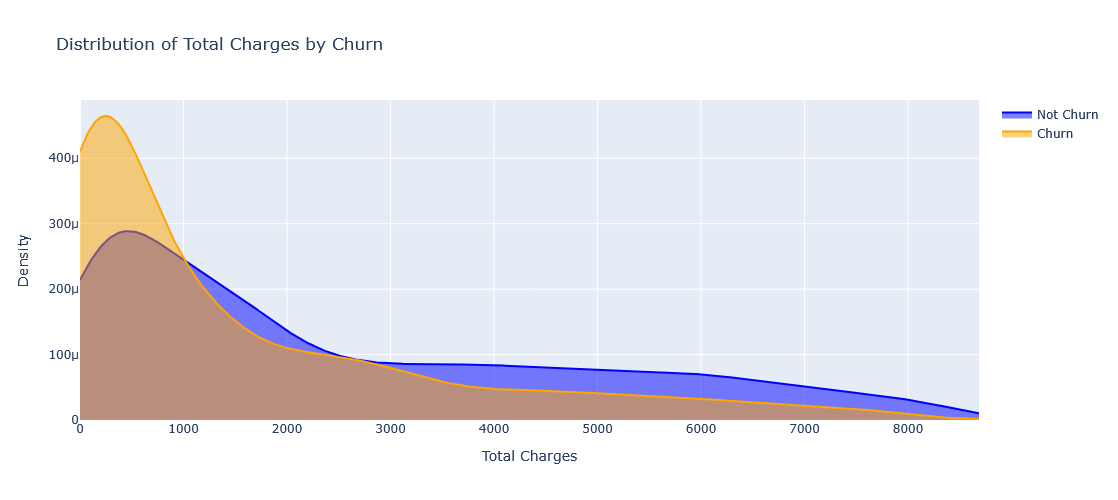

In [119]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

x_no  = df.loc[df['Churn'] == 'No',  'TotalCharges'].dropna()
x_yes = df.loc[df['Churn'] == 'Yes', 'TotalCharges'].dropna()

kde_no = gaussian_kde(x_no)
kde_yes = gaussian_kde(x_yes)

x_range = np.linspace(df['TotalCharges'].min(), df['TotalCharges'].max(), 500)

y_no = kde_no(x_range)
y_yes = kde_yes(x_range)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x_range,
    y=y_no,
    fill='tozeroy',
    name='Not Churn',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=x_range,
    y=y_yes,
    fill='tozeroy',
    name='Churn',
    line=dict(color='orange')
))

fig.update_layout(
    title='Distribution of Total Charges by Churn',
    xaxis_title='Total Charges',
    yaxis_title='Density',
    width=850,
    height=500
)

fig.show()

Customers who churn tend to have much lower Total Charges than those who stay. This is largely because many churners leave early in their customer journey, before they have had time to build up large overall spending. In contrast, customers who do not churn are spread much more widely across higher Total Charges, reflecting longer tenures and sustained relationships with the company.

This supports the earlier findings that churn is strongly an early-lifecycle behaviour for many customers. While higher monthly charges are linked to churn, Total Charges are naturally lower for churned customers simply because they have not remained with the company long enough to accumulate higher lifetime spend.

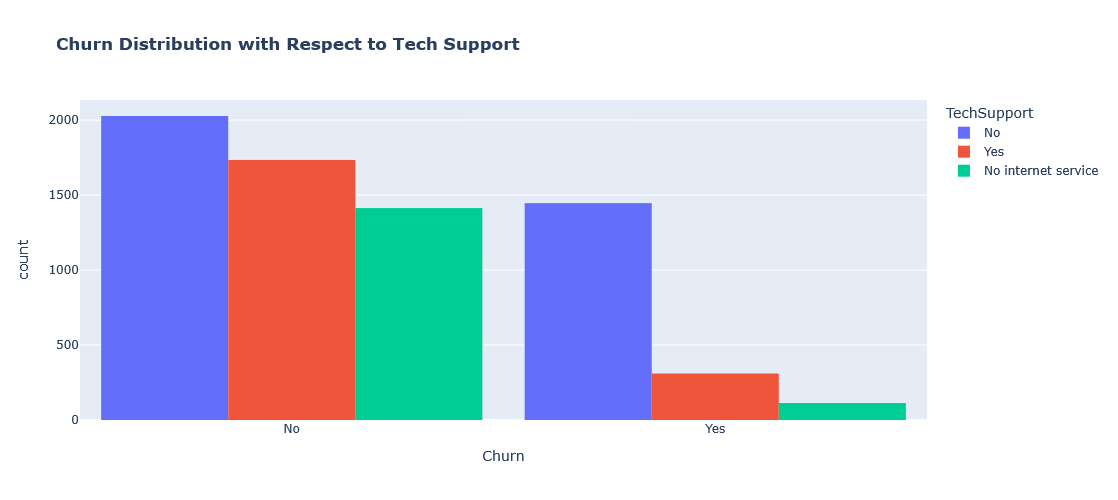

In [122]:
fig = px.histogram(
    df,
    x="Churn",
    color="TechSupport",
    barmode="group",
    title="<b>Churn Distribution with Respect to Tech Support</b>"
)

fig.update_layout(
    width=700,
    height=500,
    bargap=0.1
)

fig.show()

Customers who do not have access to technical support show noticeably higher levels of churn compared to those who do. While many customers without tech support stay, a large proportion of those who leave the service come from this group. In contrast, customers who receive technical support are far more likely to remain with the company, with relatively few choosing to churn. Customers with no internet service show the lowest churn, which is expected given their more limited service offering.

Overall, this suggests that the availability of technical support plays a meaningful role in customer retention. Having access to support appears to reduce churn, likely by helping customers resolve issues before they become reasons to leave.

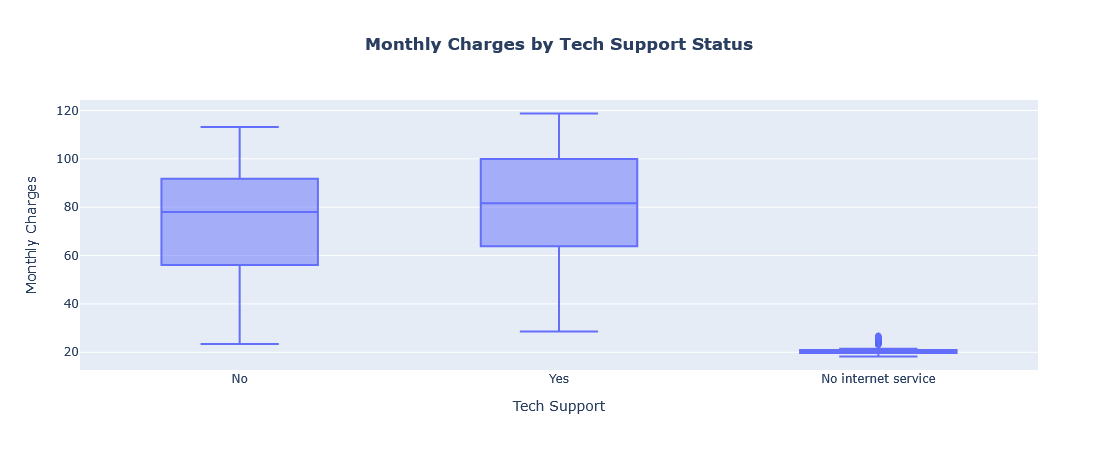

In [125]:
fig = px.box(
    df,
    x='TechSupport',
    y='MonthlyCharges',
    title='<b>Monthly Charges by Tech Support Status</b>'
)

fig.update_layout(
    width=700,
    height=450,
    xaxis_title='Tech Support',
    yaxis_title='Monthly Charges',
    title_x=0.5
)

fig.show()

In [127]:
tech_phone = pd.crosstab(
    df['TechSupport'],
    df['PhoneService'],
    normalize='index'
).mul(100)

print(tech_phone)

PhoneService                No         Yes
TechSupport                               
No                   11.315865   88.684135
No internet service   0.000000  100.000000
Yes                  14.138943   85.861057


In [129]:
price_support_churn = (
    df
    .groupby(['TechSupport', 'Churn'])['MonthlyCharges']
    .mean()
    .reset_index()
)

price_support_churn

TechSupport Churn  MonthlyCharges
0                   No    No       73.176986
1                   No   Yes       76.562794
2  No internet service    No       21.136058
3  No internet service   Yes       20.368142
4                  Yes    No       80.040802
5                  Yes   Yes       84.256290

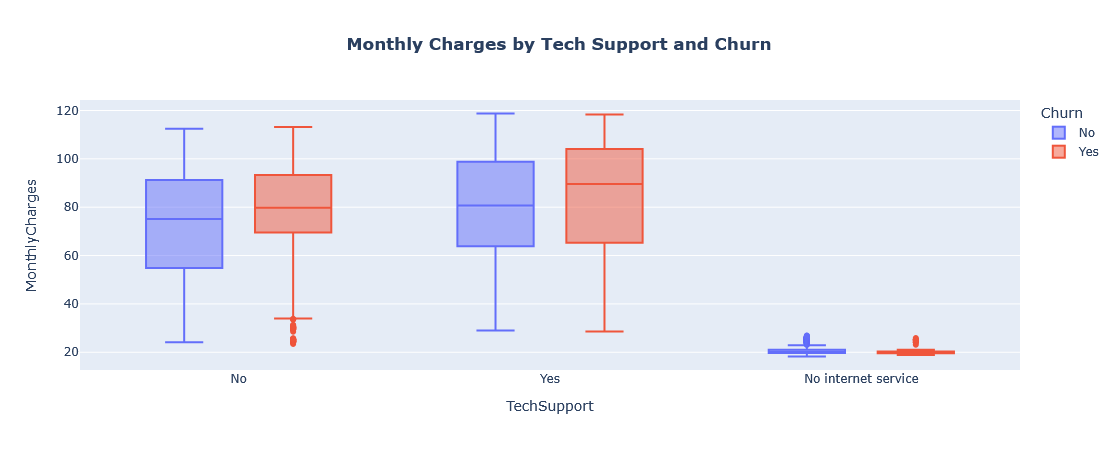

In [131]:
fig = px.box(
    df,
    x='TechSupport',
    y='MonthlyCharges',
    color='Churn',
    title='<b>Monthly Charges by Tech Support and Churn</b>'
)

fig.update_layout(
    width=750,
    height=450,
    title_x=0.5
)

fig.show()

In [133]:
senior_tech = pd.crosstab(
    df['SeniorCitizen'],
    df['TechSupport'],
    normalize='index'
).mul(100)

senior_tech

TechSupport           No  No internet service        Yes
SeniorCitizen                                           
No             44.789019            24.978817  30.232164
Yes            72.679510             4.553415  22.767075

In [135]:
pd.crosstab(
    [df['SeniorCitizen'], df['TechSupport']],
    df['Churn'],
    normalize='index'
).mul(100)

Churn                                     No        Yes
SeniorCitizen TechSupport                              
No            No                   61.180477  38.819523
              No internet service  92.672999   7.327001
              Yes                  85.482063  14.517937
Yes           No                   49.397590  50.602410
              No internet service  90.384615   9.615385
              Yes                  80.384615  19.615385

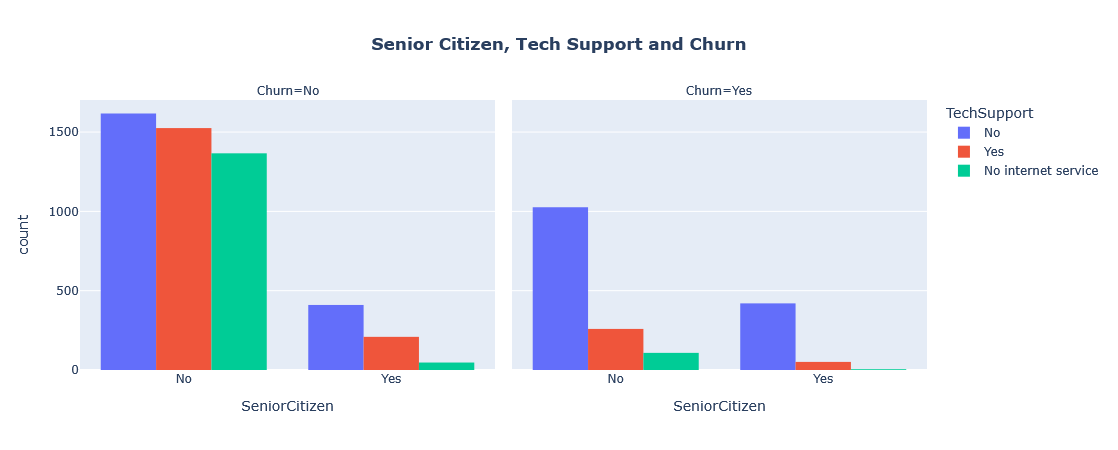

In [137]:
fig = px.histogram(
    df,
    x="SeniorCitizen",
    color="TechSupport",
    barmode="group",
    facet_col="Churn",
    title="<b>Senior Citizen, Tech Support and Churn</b>"
)

fig.update_layout(
    width=900,
    height=450,
    title_x=0.5
)

fig.show()

The analysis demonstrates a clear interaction between technical support provision, pricing, and senior citizen status in shaping churn behaviour. Customers with access to technical support generally incur higher monthly charges, reflecting their use of more comprehensive service packages. Despite this, technical support exhibits a strong protective effect against churn, with customers who have support being significantly more likely to remain with the company across all pricing levels. In contrast, customers without technical support represent the largest proportion of churners, indicating that the absence of support exacerbates dissatisfaction and exit risk. Senior citizens emerge as a particularly vulnerable cohort, exhibiting higher overall churn rates and being disproportionately represented among customers without technical support, thereby compounding their risk. Moreover, while elevated monthly charges increase churn likelihood across the dataset, this effect is most pronounced among long-term customers and senior users, suggesting that price sensitivity intensifies when combined with service accessibility barriers. Collectively, these findings indicate that churn is not driven by pricing, service provision, or demographic factors in isolation, but rather by the cumulative effect of high charges, limited technical support, and senior status.

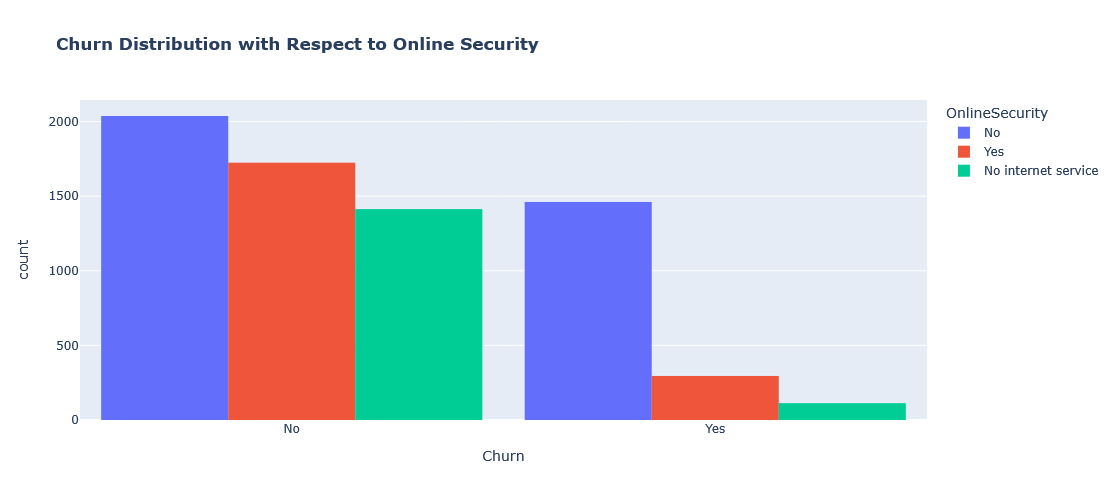

In [140]:
fig = px.histogram(
    df,
    x="Churn",
    color="OnlineSecurity",
    barmode="group",
    title="<b>Churn Distribution with Respect to Online Security</b>"
)

fig.update_layout(
    width=700,
    height=500,
    bargap=0.1
)

fig.show()

The results indicate a strong inverse relationship between the presence of Online Security and customer churn. Customers without Online Security account for the largest proportion of churned users, whereas customers with Online Security show substantially lower churn levels. This suggests that Online Security acts as a significant protective factor against churn, likely by increasing both the perceived value of the service and the customer’s level of dependency on the provider.

Customers recorded as having “No internet service” exhibit minimal churn, which is expected given their lower service complexity and sharply reduced price exposure. The sharp contrast between customers who have Online Security and those who do not reinforces the importance of value-added protection services in driving retention. Overall, this supports the broader finding that customers who adopt security and protection-based add-ons are significantly more stable and less likely to exit the service.

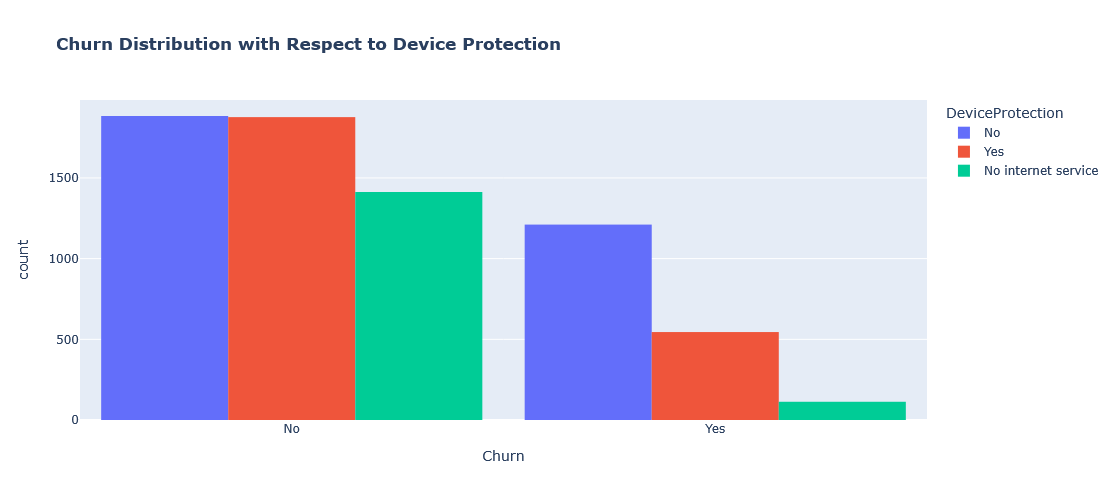

In [143]:
fig = px.histogram(
    df,
    x="Churn",
    color="DeviceProtection",
    barmode="group",
    title="<b>Churn Distribution with Respect to Device Protection</b>"
)

fig.update_layout(
    width=700,
    height=500,
    bargap=0.1
)

fig.show()

The results demonstrate a clear inverse relationship between Device Protection and customer churn. Customers without Device Protection account for a substantially larger share of total churn, while those with Device Protection exhibit markedly lower churn levels. This indicates that Device Protection, like other value-added protection services, functions as a strong retention mechanism. Customers who adopt this service are likely to be more invested in their provider and perceive greater overall value, thereby reducing their likelihood of leaving.

Customers classified as having “No internet service” again display comparatively minimal churn, which is consistent with their lower monthly charges and reduced service complexity. The contrast between customers with and without Device Protection supports the broader pattern observed across Online Security and Tech Support, namely that protective and security-based add-ons significantly increase customer stickiness. Collectively, these findings suggest that Device Protection contributes meaningfully to customer retention and should be considered a key stabilising feature within bundled service offerings.

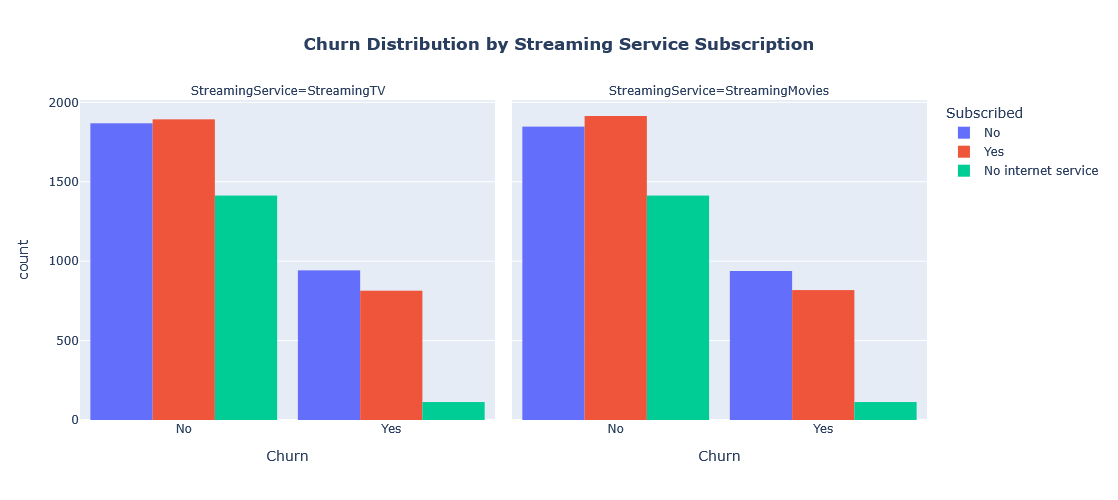

In [146]:
stream_df = df.melt(
    id_vars=['Churn'],
    value_vars=['StreamingTV', 'StreamingMovies'],
    var_name='StreamingService',
    value_name='Subscribed'
)

fig = px.histogram(
    stream_df,
    x="Churn",
    color="Subscribed",
    facet_col="StreamingService",
    barmode="group",
    title="<b>Churn Distribution by Streaming Service Subscription</b>"
)

fig.update_layout(
    width=1000,
    height=500,
    bargap=0.1,
    title_x=0.5
)

fig.show()

The distribution of churn across StreamingTV and StreamingMovies subscriptions indicates a clear relationship between entertainment service engagement and customer retention. Customers who subscribe to either StreamingTV or StreamingMovies exhibit lower levels of churn compared to those who do not subscribe. In both service categories, the majority of churned customers fall within the non-subscriber group, while subscribers are more strongly represented among retained customers. This suggests that streaming services act as an engagement-based retention mechanism, increasing the perceived value of the overall service bundle and strengthening customer attachment to the provider.

Customers categorised as having “No internet service” again display minimal churn, reflecting their structurally different, lower-cost service profile. The consistency of the retention pattern across both StreamingTV and StreamingMovies supports the broader conclusion that higher levels of service engagement systematically reduce churn risk. These findings align closely with the protective effects observed for Online Security, Device Protection, and Technical Support, reinforcing the interpretation that customers embedded within richer service ecosystems are significantly less likely to disengage from the provider.

In [149]:
protection_cols = ['OnlineSecurity', 'TechSupport', 'DeviceProtection', 'OnlineBackup']

protection_bundle = (
    df[protection_cols]
    .apply(lambda x: (x == 'Yes').sum(), axis=1)
)

service_cols = ['StreamingTV', 'StreamingMovies', 'PhoneService','InternetService',]

service_bundle = (
    df[service_cols]
    .apply(lambda x: (x == 'Yes').sum(), axis=1)
)

In [151]:
protection_churn = (
    pd.DataFrame({
        'ProtectionBundleCount': protection_bundle,
        'Churn': df['Churn']
    })
    .groupby('ProtectionBundleCount')['Churn']
    .value_counts(normalize=True)
    .mul(100)
    .rename('Percentage')
    .reset_index()
)

protection_churn

ProtectionBundleCount Churn  Percentage
0                      0    No   70.247046
1                      0   Yes   29.752954
2                      1    No   61.145194
3                      1   Yes   38.854806
4                      2    No   76.239067
5                      2   Yes   23.760933
6                      3    No   87.566419
7                      3   Yes   12.433581
8                      4    No   94.680851
9                      4   Yes    5.319149

In [153]:
service_churn = (
    pd.DataFrame({
        'ServiceBundleCount': service_bundle,
        'Churn': df['Churn']
    })
    .groupby('ServiceBundleCount')['Churn']
    .value_counts(normalize=True)
    .mul(100)
    .rename('Percentage')
    .reset_index()
)

service_churn

ServiceBundleCount Churn  Percentage
0                   0    No   74.247492
1                   0   Yes   25.752508
2                   1    No   77.217036
3                   1   Yes   22.782964
4                   2    No   69.352792
5                   2   Yes   30.647208
6                   3    No   69.655172
7                   3   Yes   30.344828

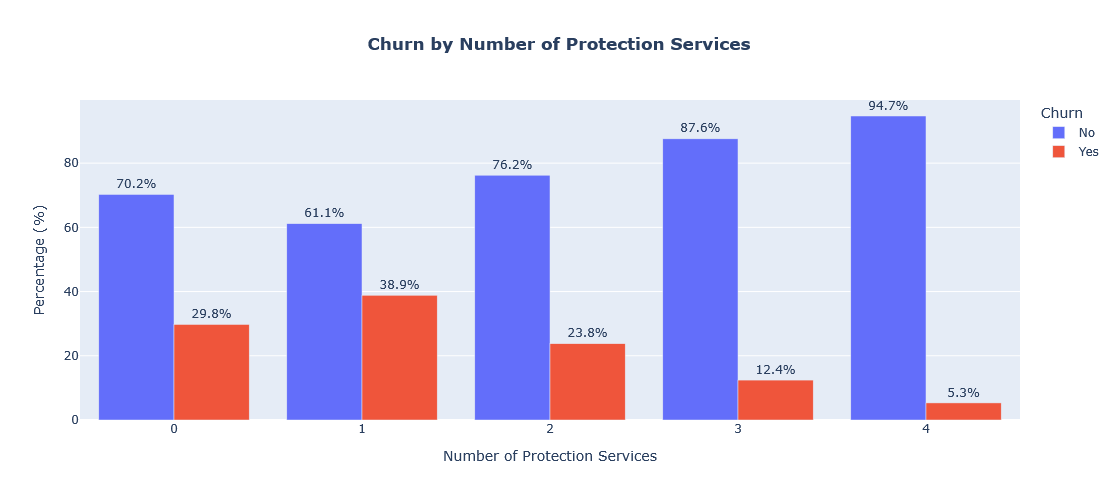

In [155]:
fig = px.bar(
    protection_churn,
    x='ProtectionBundleCount',
    y='Percentage',
    color='Churn',
    barmode='group',
    title='<b>Churn by Number of Protection Services</b>',
    text='Percentage'
)

fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_layout(
    width=700,
    height=500,
    xaxis_title='Number of Protection Services',
    yaxis_title='Percentage (%)',
    title_x=0.5
)

fig.show()

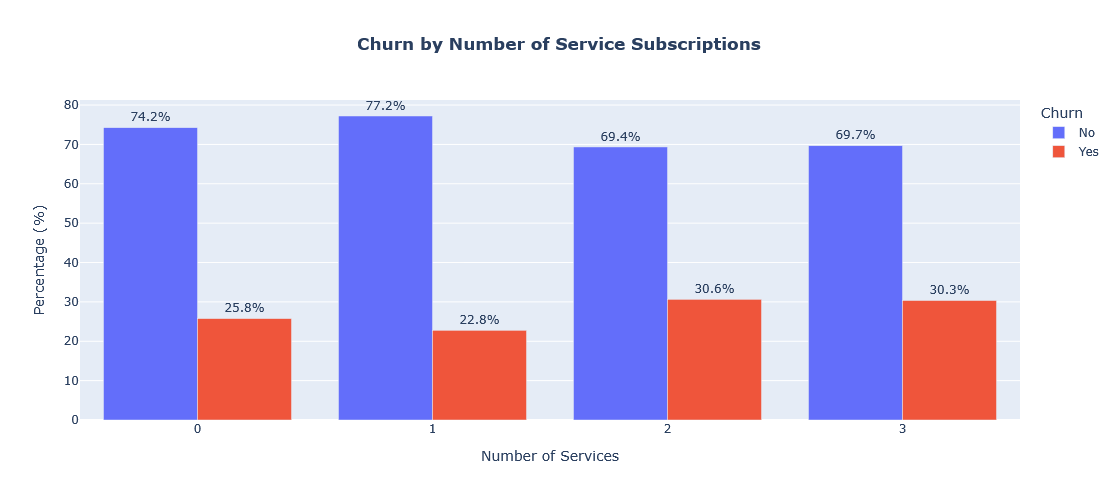

In [157]:
fig = px.bar(
    service_churn,
    x='ServiceBundleCount',
    y='Percentage',
    color='Churn',
    barmode='group',
    title='<b>Churn by Number of Service Subscriptions</b>',
    text='Percentage'
)

fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_layout(
    width=700,
    height=500,
    xaxis_title='Number of Services',
    yaxis_title='Percentage (%)',
    title_x=0.5
)

fig.show()

To examine whether churn is influenced by the cumulative depth of customer service adoption rather than individual services in isolation, two composite bundle measures were constructed. A protection bundle was derived by aggregating the number of protection-based services held by each customer, namely Online Security, Technical Support, Device Protection, and Online Backup. In parallel, a service (engagement) bundle was created to capture broader service usage, based on Streaming TV, Streaming Movies, and Phone Service. These bundle counts represent the total number of relevant services subscribed to by each customer and were analysed independently of the original dataset structure to preserve data integrity. This approach allows for the assessment of whether increasing levels of service integration reduce churn in a cumulative manner.

The bundle analysis reveals a striking contrast between the effects of protection services and general service subscriptions on customer churn. For the protection bundle, a clear and monotonic relationship is observed: churn decreases sharply as the number of protection services increases. Customers with no protection services exhibit a churn rate of 29.8%, which initially rises to 38.9% among those with only one protection service, before falling substantially to 23.8% with two services, 12.4% with three services, and just 5.3% among customers subscribing to all four protection services. This strong downward gradient demonstrates a powerful cumulative protective effect, indicating that customers embedded within multiple protection-based services are significantly more stable and highly unlikely to churn.

In contrast, the service (engagement) bundle does not display the same stabilising pattern. Churn remains relatively flat across service counts, with rates of 25.8% for customers with no services, 22.8% for one service, 30.6% for two services, and 30.3% for three services. Unlike the protection bundle, increasing the number of general service subscriptions does not systematically reduce churn and, at higher service counts, is associated with slightly increased churn. This suggests that while general services may increase usage and short-term engagement, they do not confer the same long-term retention benefit as protection-based services.

Collectively, these findings indicate that customer retention is driven more strongly by the depth of protective service integration than by the breadth of service consumption alone. Protection services appear to create structural dependency, perceived value, and switching barriers that substantially suppress churn. In contrast, general service subscriptions function primarily as engagement tools rather than retention anchors. This distinction has clear strategic implications: bundling and promoting protection services represents a far more effective long-term churn mitigation strategy than expanding entertainment or connectivity services alone.

# Model Experiments

In [161]:
df.head()

gender SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female            No     Yes         No       1           No   
1    Male            No      No         No      34          Yes   
2    Male            No      No         No       2          Yes   
3    Male            No      No         No      45           No   
4  Female            No      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges  TotalCharges  \
0              Yes           Electronic check           29.85         29.85   
1               No               Mailed check           56.95       1889.50   
2              Yes               Mailed check           53.85        108.15   
3               No  Bank transfer (automatic)           42.30       1840.75   
4              Yes           Electronic check           70.70        151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

In [163]:
df.drop(columns=['gender'],inplace=True)

we drop Gender as it shows the least relationship with churn and most other metrics, this will also help reduce random noise for the models

In [166]:
print(df.columns)

Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'],
      dtype='object')


First we need to make the data suitable for a model so we need to turn these categorical columns into numerical formats using onehot encoding

In [169]:
X = df.drop('Churn', axis=1)
y = df['Churn'].map({'No': 0, 'Yes': 1})

In [171]:
cat_features = X.select_dtypes(include=['object']).columns.tolist()
num_features = X.select_dtypes(exclude=['object']).columns.tolist()

In [173]:
encoder_ohe = OneHotEncoder(       
    sparse_output=False, 
    handle_unknown='ignore'
)

encoder_label = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1
)


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', encoder_label, cat_features),
        ('num', 'passthrough', num_features)
    ]
)

we now split the data using stratified split due to use having an imbalanced dataset

In [176]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

so above we have setup the transformer for the features to be transformed when we run the model and using it we split the data, now we setup the main scoring metrics, and models

In [179]:
f2_scorer = make_scorer(fbeta_score, beta=2)

In [181]:
log_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    solver='liblinear'
)

rf_model = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

gb_model = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)


lgbm_model = LGBMClassifier(
     n_estimators=500,
     learning_rate=0.05,
     num_leaves=31,
     class_weight='balanced',
     random_state=42
)


In [183]:
pipelines = {
    "Logistic Regression": Pipeline([
        ('preprocessor', preprocessor),
        ('model', log_model)
    ]),
    "Random Forest": Pipeline([
        ('preprocessor', preprocessor),
        ('model', rf_model)
    ]),
    "Gradient Boosting": Pipeline([
        ('preprocessor', preprocessor),
        ('model', gb_model)
    ]),
    "LightGBM": Pipeline([
        ('preprocessor', preprocessor),
        ('model', lgbm_model)
    ])
}

In [185]:
scoring = {
    'f2': f2_scorer,
    'recall': 'recall',
    'precision': 'precision',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'pr_auc': 'average_precision'
}

ok now we run the models

In [188]:
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

In [190]:
cv_summary = {}
test_confusion_matrices = {}

print("=== Cross-Validation Baseline Results ===\n")

for name, pipe in pipelines.items():
    cv_results = cross_validate(
        pipe,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=True
    )
    
    summary = {
        metric: (cv_results[f'test_{metric}'].mean(), cv_results[f'test_{metric}'].std())
        for metric in scoring.keys()
    }
    cv_summary[name] = summary
    
    print(f"{name}:")
    print("  Cross-Validation Results:")
    for metric, (mean_val, std_val) in summary.items():
        print(f"    {metric.upper():7s}: {mean_val:.4f} ± {std_val:.4f}")
    print("\n")

    pipe.fit(X_train, y_train)
    
    y_test_pred = pipe.predict(X_test)
    
    
    cm = confusion_matrix(y_test, y_test_pred)
    test_confusion_matrices[name] = cm
    
    print("Confusion Matrix:")
    print(cm)
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred, digits=4))

=== Cross-Validation Baseline Results ===

Logistic Regression:
  Cross-Validation Results:
    F2     : 0.7213 ± 0.0201
    RECALL : 0.8027 ± 0.0214
    PRECISION: 0.5138 ± 0.0243
    F1     : 0.6263 ± 0.0218
    ROC_AUC: 0.8438 ± 0.0112
    PR_AUC : 0.6601 ± 0.0156


Confusion Matrix:
[[1119  433]
 [ 120  441]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9031    0.7210    0.8019      1552
           1     0.5046    0.7861    0.6146       561

    accuracy                         0.7383      2113
   macro avg     0.7039    0.7536    0.7082      2113
weighted avg     0.7973    0.7383    0.7522      2113

Random Forest:
  Cross-Validation Results:
    F2     : 0.5142 ± 0.0116
    RECALL : 0.4893 ± 0.0125
    PRECISION: 0.6459 ± 0.0098
    F1     : 0.5567 ± 0.0100
    ROC_AUC: 0.8289 ± 0.0083
    PR_AUC : 0.6359 ± 0.0173


Confusion Matrix:
[[1396  156]
 [ 299  262]]

Classification Report:
              precision    recall  f1-score 

C:\Users\thede\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



So above are the models tested, 4 where chosen, logistical regression, LightGBM, Random Forest and SKlearns Gradient Booster. all models where tested as baseline models this means they were trained using the same prepared dataset and evaluation approach, but without any detailed fine-tuning of their internal settings, this is done to allow for a fair and transparent comparison of how each model naturally performs before optimisation.

From the results above Logistic Regression performed best at identifying customers who go on to churn having the highest F2 score and recall. In simple terms, this model is the best at spotting at-risk customers early, which is important because the main goal of churn modelling is to avoid missing customers who are likely to leave however, this strength comes with a drawback as it also flags many customers as high risk who would not actually churn, leading to a larger number of false alarms meaning more customers would be targeted than necessary, which could increase operational costs.

Random Forest and Gradient Boosting performed very well at identifying customers who are not going to churn, achieving the highest overall accuracy but as stated before this isnt the best metric for churn prediction models and as such they performed poorly at detecting actual churners meaning they would be good at avoiding unnecessary intervention, but they would miss many customers who are genuinely at risk of leaving, which undermines the purpose of a churn prediction system. For this reason, despite their high accuracy, these models are less suitable when the priority is catching as many churners as possible.

LightGBM provided the most balanced performance overall as it detected a high proportion of churners while also keeping the number of false alarms at a more manageable level than Logistic Regression so in other words, it offers a strong middle ground between finding churners and avoiding unnecessary intervention. It also has the advantage of being a powerful model that can learn complex patterns and interactions in the data, such as how pricing, contract type and service usage combine to influence churn.

From this analysis of the baseline models i've decided that LightGBM to be the model we should look at for further improvement. the reasons for this is because LightGBM provides a nice balance between catching customers who are likely to churn whilst not blindly firing churn labels at non-churners. LightGBM is also very well suited to handle higher complex datasets because it can automatically learn non-linear patterns and interactions between variables meaning the model can capture more subtle relationships between features in the data that simpler linear models have a hard time finding, this is particularly important due to what we found in the data exploration earlier when it comes to what feature combinations drove churn like the relationship between pricing and tenure or the relationship between the amount of security services to churn and as such by LightGBM having these capabilities its better positioned to hopefully reflect the true underlying drivers of churn and should offer the greatest potential for improvement among the models.

So here we will now do some steps to improve lightgbm, first is to do some Hyperparameter tuning where we are still optimising for f2 score but also looking at other metrics

For LightGBM the hyperparameter optimisation was pushed to help balance the models complexity and learning stability while trying to keep it fairly efficient for this sized dataset. This tuning was carried out using Randomised Search with cross-validation to test a wide range of model settings, the model was tested with slower, more stable and faster learning parameters to help it not over-react to noise or any missed important patterns, it was also adjusted to how complex the decision tress could become to help find the sweet spot of picking up simple trends and subtle relationships between features and to help with any bias the model also played with different child sizes to help counteract the model being bias towards any small or unusual customer groups. Finally a controlled randomness was introduced to help prevent overfitting and to makesure the model could perform well on new data, these practices where chosen following a research paper exploring LightGBM and other gradient-boosted models

This optimisation process strengthens the reliability and practical value of the final churn model. Rather than relying on a single set of default model settings, hyperparameter tuning allows the algorithm to be tailored specifically to the structure and behaviour within this dataset. By testing different learning behaviours and model structures, the approach reduces the risk of underfitting or overfitting and increases confidence that the model will perform well on new, unseen customers. Using cross-validation further ensures that the results are not driven by chance splits in the data, while evaluating multiple metrics allows performance to be judged from both a statistical and business perspective which makes this approach produces a more robust, generalisable, and deployment-ready model that can be trusted.

In [192]:
lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', lgbm_model)
])

param_dist = {
    'model__n_estimators': [200, 300, 400, 500],
    'model__learning_rate': [0.01, 0.03, 0.05, 0.1],
    'model__num_leaves': [3, 5, 15, 31, 63, 127],
    'model__max_depth': [-1, 3, 5, 7, 9],
    'model__min_child_samples': [10, 20, 30, 50],
    'model__subsample': [0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}


lgbm_search_multi = RandomizedSearchCV(
    estimator=lgbm_pipeline,
    param_distributions=param_dist,
    n_iter=100,
    scoring=scoring,
    refit=False,          
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

lgbm_search_multi.fit(X_train, y_train)

cv_results = pd.DataFrame(lgbm_search_multi.cv_results_)
cv_results.head()

Fitting 5 folds for each of 100 candidates, totalling 500 fits


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      25.543748      0.067190         0.053548        0.006815   
1      12.986526     10.070999         0.049219        0.003250   
2       2.857650      2.226095         0.061279        0.002672   
3       0.690876      0.014001         0.046723        0.002963   
4       0.466994      0.021014         0.048043        0.003238   

   param_model__subsample  param_model__num_leaves  param_model__n_estimators  \
0                     0.9                       31                        300   
1                     1.0                        3                        400   
2                     0.7                      127                        500   
3                     0.9                       31                        200   
4                     0.9                       63                        300   

   param_model__min_child_samples  param_model__max_depth  \
0                              30                       3   
1                              10                       3   
2                              10                       5   
3                              10                       9   
4                              30                       5   

   param_model__learning_rate  ...  std_test_roc_auc rank_test_roc_auc  \
0                        0.01  ...          0.012333                45   
1                        0.01  ...          0.013411                53   
2                        0.01  ...          0.010235                35   
3                        0.05  ...          0.010096                66   
4                        0.10  ...          0.010783                95   

   split0_test_pr_auc  split1_test_pr_auc  split2_test_pr_auc  \
0            0.678092            0.683521            0.638980   
1            0.668799            0.682317            0.622718   
2            0.673533            0.678326            0.654075   
3            0.661077            0.672659            0.649185   
4            0.636969            0.654827            0.644615   

   split3_test_pr_auc  split4_test_pr_auc  mean_test_pr_auc  std_test_pr_auc  \
0            0.632842            0.680736          0.662834         0.022135   
1            0.628925            0.684732          0.657498         0.026501   
2            0.644563            0.687240          0.667547         0.015809   
3            0.631711            0.678783          0.658683         0.016869   
4            0.621207            0.667661          0.645056         0.015753   

   rank_test_pr_auc  
0                53  
1                69  
2                35  
3                65  
4                88  

[5 rows x 60 columns]

Now that we have 5 of the best hyperparameters for varying different metrics we can now look at getting the best results for each metric and threshold

This is done by selecting a decision threshold, which directly controls the trade-off between recall and precision. Optimising purely for recall would allow the model to identify almost all churners, but this would come at the cost of flagging a large number of non-churning customers incorrectly. Conversely, optimising purely for precision would ensure that most flagged customers truly are churners, but would cause many genuine churners to be missed. In a real business context, neither extreme is desirable. The objective in the part below is to detect as many at-risk customers as possible while maintaining a reasonable level of confidence that those flagged are genuinely likely to leave. For this reason, thresholds were systematically explored from 0.1-0.95 in increments of 0.05 to give us the a table of models that are tuned for different metrics and then predicting on different thresholds

In [195]:
cv_df = pd.DataFrame(cv_results)
metrics_to_try = ['f2', 'recall', 'precision', 'f1', 'roc_auc', 'pr_auc']
top_k = 5
best_combos = []

for metric_name in metrics_to_try:
    top_k_rows = cv_df.nlargest(top_k, 'mean_test_' + metric_name)


    for rank_idx, (_, row) in enumerate(top_k_rows.iterrows(), start=1):
        params = row['params']

        
        pipe = clone(lgbm_pipeline)
        pipe.set_params(**params)
        pipe.fit(X_train, y_train)

        
        y_prob = pipe.predict_proba(X_test)[:, 1]

        
        thresholds = np.arange(0.1, 1.0, 0.05)
        best_f2 = -1
        best_t = None
        best_metrics = {}

        for t in thresholds:
            y_pred_t = (y_prob > t).astype(int)

            f2 = fbeta_score(y_test, y_pred_t, beta=2)
            rec = recall_score(y_test, y_pred_t)
            prec = precision_score(y_test, y_pred_t)
            f1 = f1_score(y_test, y_pred_t)

            if f2 > best_f2:
                best_f2 = f2
                best_t = t
                best_metrics = {
                    'F2': f2,
                    'Recall': rec,
                    'Precision': prec,
                    'F1': f1,
                    'ROC_AUC': roc_auc_score(y_test, y_prob),
                    'PR_AUC': average_precision_score(y_test, y_prob),
                    'CM': confusion_matrix(y_test, y_pred_t)
                }

        best_combos.append({
            'tuned_on': metric_name,
            'config_rank': rank_idx,
            'threshold': best_t,
            **best_metrics,
            'params': params
        })

best_df = pd.DataFrame(best_combos)

[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\thede\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

C:\Users\thede\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\thede\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\thede\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\thede\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

C:\Users\thede\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\thede\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\thede\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\thede\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\thede\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

C:\Users\thede\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\thede\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\thede\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

C:\Users\thede\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\thede\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\thede\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

C:\Users\thede\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\thede\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\thede\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\thede\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

C:\Users\thede\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\thede\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\thede\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\thede\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

C:\Users\thede\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\thede\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\thede\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\thede\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

C:\Users\thede\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\thede\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\thede\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

C:\Users\thede\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\thede\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\thede\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\thede\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\thede\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

C:\Users\thede\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\thede\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\thede\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\thede\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\thede\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

C:\Users\thede\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

C:\Users\thede\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\thede\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\thede\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

C:\Users\thede\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\thede\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\thede\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

C:\Users\thede\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\thede\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\thede\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\thede\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\thede\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

C:\Users\thede\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



In [196]:
best_df_sorted = best_df.sort_values('Recall', ascending=False)
best_df_sorted.head(10)

tuned_on  config_rank  threshold        F2    Recall  Precision        F1  \
7    recall            3       0.30  0.746998  0.953654   0.400150  0.563751   
0        f2            1       0.30  0.747480  0.951872   0.402108  0.565379   
5    recall            1       0.30  0.747480  0.951872   0.402108  0.565379   
1        f2            2       0.30  0.745934  0.948307   0.402421  0.565056   
6    recall            2       0.30  0.745934  0.948307   0.402421  0.565056   
3        f2            4       0.30  0.750640  0.941176   0.414768  0.575791   
4        f2            5       0.30  0.750640  0.941176   0.414768  0.575791   
8    recall            4       0.30  0.750640  0.941176   0.414768  0.575791   
9    recall            5       0.30  0.750640  0.941176   0.414768  0.575791   
25   pr_auc            1       0.25  0.741217  0.925134   0.412888  0.570957   

     ROC_AUC    PR_AUC                       CM  \
7   0.835394  0.634220  [[750, 802], [26, 535]]   
0   0.837033  0.634778  [[758, 794], [27, 534]]   
5   0.837033  0.634778  [[758, 794], [27, 534]]   
1   0.835834  0.641499  [[762, 790], [29, 532]]   
6   0.835834  0.641499  [[762, 790], [29, 532]]   
3   0.837490  0.645084  [[807, 745], [33, 528]]   
4   0.837490  0.645084  [[807, 745], [33, 528]]   
8   0.837490  0.645084  [[807, 745], [33, 528]]   
9   0.837490  0.645084  [[807, 745], [33, 528]]   
25  0.840887  0.655169  [[814, 738], [42, 519]]   

                                               params  
7   {'model__subsample': 0.8, 'model__num_leaves':...  
0   {'model__subsample': 0.9, 'model__num_leaves':...  
5   {'model__subsample': 0.9, 'model__num_leaves':...  
1   {'model__subsample': 0.9, 'model__num_leaves':...  
6   {'model__subsample': 0.9, 'model__num_leaves':...  
3   {'model__subsample': 1.0, 'model__num_leaves':...  
4   {'model__subsample': 0.9, 'model__num_leaves':...  
8   {'model__subsample': 1.0, 'model__num_leaves':...  
9   {'model__subsample': 0.9, 'model__num_leaves':...  
25  {'model__subsample': 0.8, 'model__num_leaves':...

In [197]:
best_df_sorted = best_df.sort_values('Precision', ascending=False)
best_df_sorted.head(10)

tuned_on  config_rank  threshold        F2    Recall  Precision  \
15         f1            1       0.30  0.748340  0.884135   0.463551   
10  precision            1       0.10  0.705247  0.814617   0.458835   
17         f1            3       0.30  0.744012  0.885918   0.453467   
11  precision            2       0.15  0.738975  0.884135   0.446043   
16         f1            2       0.30  0.745406  0.896613   0.445133   
19         f1            5       0.30  0.745562  0.898396   0.443662   
2          f2            3       0.30  0.748239  0.909091   0.438144   
26     pr_auc            2       0.30  0.748239  0.909091   0.438144   
20    roc_auc            1       0.30  0.748239  0.909091   0.438144   
21    roc_auc            2       0.30  0.747362  0.909091   0.436644   

          F1   ROC_AUC    PR_AUC                         CM  \
15  0.608216  0.834851  0.644718    [[978, 574], [65, 496]]   
10  0.587026  0.813570  0.595247  [[1013, 539], [104, 457]]   
17  0.599879  0.837270  0.646985    [[953, 599], [64, 497]]   
11  0.592947  0.821152  0.616773    [[936, 616], [65, 496]]   
16  0.594914  0.837102  0.646540    [[925, 627], [58, 503]]   
19  0.593989  0.837793  0.648293    [[920, 632], [57, 504]]   
2   0.591304  0.843416  0.655902    [[898, 654], [51, 510]]   
26  0.591304  0.843416  0.655902    [[898, 654], [51, 510]]   
20  0.591304  0.843416  0.655902    [[898, 654], [51, 510]]   
21  0.589936  0.843439  0.657395    [[894, 658], [51, 510]]   

                                               params  
15  {'model__subsample': 1.0, 'model__num_leaves':...  
10  {'model__subsample': 0.7, 'model__num_leaves':...  
17  {'model__subsample': 0.7, 'model__num_leaves':...  
11  {'model__subsample': 1.0, 'model__num_leaves':...  
16  {'model__subsample': 1.0, 'model__num_leaves':...  
19  {'model__subsample': 1.0, 'model__num_leaves':...  
2   {'model__subsample': 1.0, 'model__num_leaves':...  
26  {'model__subsample': 1.0, 'model__num_leaves':...  
20  {'model__subsample': 1.0, 'model__num_leaves':...  
21  {'model__subsample': 0.8, 'model__num_leaves':...

In [198]:
best_df_sorted = best_df.sort_values('F2', ascending=False)
best_df_sorted.head(10)

tuned_on  config_rank  threshold        F2    Recall  Precision        F1  \
9    recall            5        0.3  0.750640  0.941176   0.414768  0.575791   
3        f2            4        0.3  0.750640  0.941176   0.414768  0.575791   
4        f2            5        0.3  0.750640  0.941176   0.414768  0.575791   
8    recall            4        0.3  0.750640  0.941176   0.414768  0.575791   
15       f1            1        0.3  0.748340  0.884135   0.463551  0.608216   
2        f2            3        0.3  0.748239  0.909091   0.438144  0.591304   
26   pr_auc            2        0.3  0.748239  0.909091   0.438144  0.591304   
20  roc_auc            1        0.3  0.748239  0.909091   0.438144  0.591304   
24  roc_auc            5        0.3  0.748180  0.916221   0.431570  0.586758   
29   pr_auc            5        0.3  0.748101  0.912656   0.434635  0.588844   

     ROC_AUC    PR_AUC                       CM  \
9   0.837490  0.645084  [[807, 745], [33, 528]]   
3   0.837490  0.645084  [[807, 745], [33, 528]]   
4   0.837490  0.645084  [[807, 745], [33, 528]]   
8   0.837490  0.645084  [[807, 745], [33, 528]]   
15  0.834851  0.644718  [[978, 574], [65, 496]]   
2   0.843416  0.655902  [[898, 654], [51, 510]]   
26  0.843416  0.655902  [[898, 654], [51, 510]]   
20  0.843416  0.655902  [[898, 654], [51, 510]]   
24  0.842901  0.655012  [[875, 677], [47, 514]]   
29  0.843338  0.657703  [[886, 666], [49, 512]]   

                                               params  
9   {'model__subsample': 0.9, 'model__num_leaves':...  
3   {'model__subsample': 1.0, 'model__num_leaves':...  
4   {'model__subsample': 0.9, 'model__num_leaves':...  
8   {'model__subsample': 1.0, 'model__num_leaves':...  
15  {'model__subsample': 1.0, 'model__num_leaves':...  
2   {'model__subsample': 1.0, 'model__num_leaves':...  
26  {'model__subsample': 1.0, 'model__num_leaves':...  
20  {'model__subsample': 1.0, 'model__num_leaves':...  
24  {'model__subsample': 0.7, 'model__num_leaves':...  
29  {'model__subsample': 0.9, 'model__num_leaves':...

In [199]:
best_df_sorted = best_df.sort_values('F1', ascending=False)
best_df_sorted.head(10)

tuned_on  config_rank  threshold        F2    Recall  Precision  \
15         f1            1       0.30  0.748340  0.884135   0.463551   
17         f1            3       0.30  0.744012  0.885918   0.453467   
16         f1            2       0.30  0.745406  0.896613   0.445133   
19         f1            5       0.30  0.745562  0.898396   0.443662   
11  precision            2       0.15  0.738975  0.884135   0.446043   
2          f2            3       0.30  0.748239  0.909091   0.438144   
26     pr_auc            2       0.30  0.748239  0.909091   0.438144   
20    roc_auc            1       0.30  0.748239  0.909091   0.438144   
21    roc_auc            2       0.30  0.747362  0.909091   0.436644   
29     pr_auc            5       0.30  0.748101  0.912656   0.434635   

          F1   ROC_AUC    PR_AUC                       CM  \
15  0.608216  0.834851  0.644718  [[978, 574], [65, 496]]   
17  0.599879  0.837270  0.646985  [[953, 599], [64, 497]]   
16  0.594914  0.837102  0.646540  [[925, 627], [58, 503]]   
19  0.593989  0.837793  0.648293  [[920, 632], [57, 504]]   
11  0.592947  0.821152  0.616773  [[936, 616], [65, 496]]   
2   0.591304  0.843416  0.655902  [[898, 654], [51, 510]]   
26  0.591304  0.843416  0.655902  [[898, 654], [51, 510]]   
20  0.591304  0.843416  0.655902  [[898, 654], [51, 510]]   
21  0.589936  0.843439  0.657395  [[894, 658], [51, 510]]   
29  0.588844  0.843338  0.657703  [[886, 666], [49, 512]]   

                                               params  
15  {'model__subsample': 1.0, 'model__num_leaves':...  
17  {'model__subsample': 0.7, 'model__num_leaves':...  
16  {'model__subsample': 1.0, 'model__num_leaves':...  
19  {'model__subsample': 1.0, 'model__num_leaves':...  
11  {'model__subsample': 1.0, 'model__num_leaves':...  
2   {'model__subsample': 1.0, 'model__num_leaves':...  
26  {'model__subsample': 1.0, 'model__num_leaves':...  
20  {'model__subsample': 1.0, 'model__num_leaves':...  
21  {'model__subsample': 0.8, 'model__num_leaves':...  
29  {'model__subsample': 0.9, 'model__num_leaves':...

Once the model is trained, we still have to decide where to draw the line between a customer being labelled as “likely to churn” or “not likely to churn”. This choice of threshold is really important because it controls the balance between recall and precision. If we only focus on recall, the model will catch almost every churner, but it will also wrongly flag lots of loyal customers as at risk. On the other hand, if we only focus on precision, the model will only flag customers it is very confident about, but it will miss many people who actually are going to leave. In practice, neither of these extremes is helpful. What we really want is to identify as many customers who might churn as possible while still being reasonably confident that the customers we flag are genuinely at risk. the problem here is that we need to make a decision between what kind of metrics we want to be best and as stated above F2 is a major focus but we dont want the precision to suffer too much so what we need to do is rank each output by how well they did in their respected metric and find the most balanced of all.

In [266]:
ranking_df = best_df.copy()

metrics_to_rank = [
    'F2',
    'Recall',
    'Precision',
    'F1',
    'ROC_AUC',
    'PR_AUC'
]

for m in metrics_to_rank:
    ranking_df[m + '_rank'] = ranking_df[m].rank(ascending=False)

ranking_df['total_rank_score'] = ranking_df[[m + '_rank' for m in metrics_to_rank]].sum(axis=1)
best_overall_row = ranking_df.loc[ranking_df['total_rank_score'].idxmin()]
best_overall_row

tuned_on                                                           f2
config_rank                                                         3
threshold                                                         0.3
F2                                                           0.748239
Recall                                                       0.909091
Precision                                                    0.438144
F1                                                           0.591304
ROC_AUC                                                      0.843416
PR_AUC                                                       0.655902
CM                                            [[898, 654], [51, 510]]
params              {'model__subsample': 1.0, 'model__num_leaves':...
F2_rank                                                           7.0
Recall_rank                                                      17.5
Precision_rank                                                    8.0
F1_rank             

So here we see that we took the best hyperparameter config rated from the earlier tuning and then ran it again with a focus on PR_AUC which is the Area under the precision-recall curve which gave us a good middleground of all the metrics keeping to a relatively high recall and f2 score whilst not forsaking precision. we can see that this iteration missed 51 out of the 561 churn customers it was given but importantly only mistook 1/3 non-churning customers as churned which is pretty good compared to other results, this comes out to around 90% accuracy on churned customers and 60% on non churned customers.

In [269]:
best_params = best_overall_row['params']

final_model = clone(lgbm_pipeline)
final_model.set_params(**best_params)
final_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['SeniorCitizen', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('num', 'passthrough',
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('model',
                 LGBMClassifier(class_weight='balanced', colsample_bytree=0.7,
                                learning_rate=0.05, n_estimators=200,
                                num_leaves=5, random_state=42))])

In [271]:
y_proba = final_model.predict_proba(X_test)[:, 1]
threshold = 0.3
y_pred= (y_proba >= threshold).astype(int)

metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 score": f1_score(y_test, y_pred),
    "F2 score": fbeta_score(y_test, y_pred, beta=2),
    "ROC AUC": roc_auc_score(y_test, y_proba),
}
cm = confusion_matrix(y_test, y_pred)

metrics_df = (
    pd.Series(metrics)
    .round(3)
    .reset_index()
    .rename(columns={"index": "Metric", 0: "Value"})
)

C:\Users\thede\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



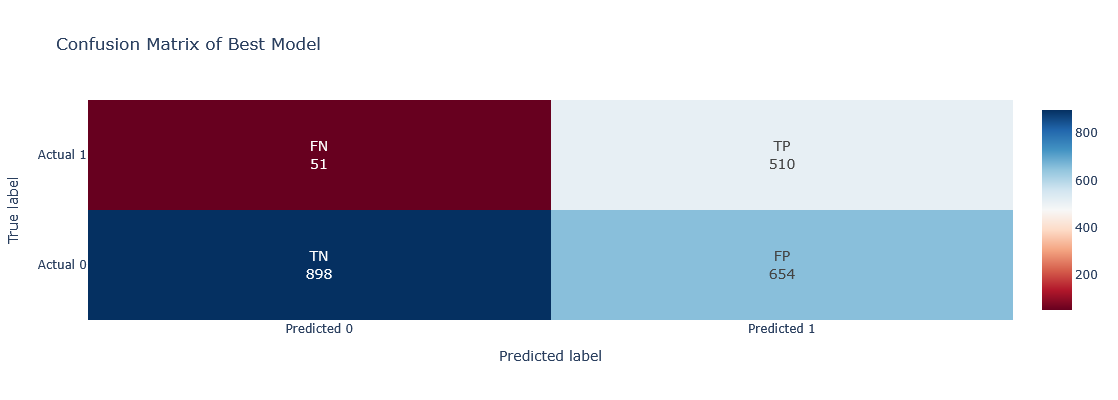

In [279]:
labels = np.array([["TN", "FP"], ["FN", "TP"]])
text = np.empty_like(cm).astype(str)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text[i, j] = f"{labels[i, j]}<br>{cm[i, j]}"

fig_cm = go.Figure(
    data=go.Heatmap(
        z=cm,
        x=["Predicted 0", "Predicted 1"],
        y=["Actual 0", "Actual 1"],
        text=text,
        texttemplate="%{text}",
        textfont={"size": 14},
        showscale=True,
        hovertemplate=" %{y} / %{x}<br>Count: %{z}<extra></extra>",
        colorscale='RdBu'
    )
)
fig_cm.update_layout(
    title="Confusion Matrix of Best Model",
    xaxis_title="Predicted label",
    yaxis_title="True label",
    width = 400, height = 400
)
fig_cm.show()

In [206]:
ct = final_model.named_steps['preprocessor']
cat_encoder = ct.named_transformers_['cat']   

cat_original = cat_features                      
cat_feature_names = cat_encoder.get_feature_names_out(cat_original)
num_feature_names = num_features
all_feature_names = list(cat_feature_names) + list(num_feature_names)

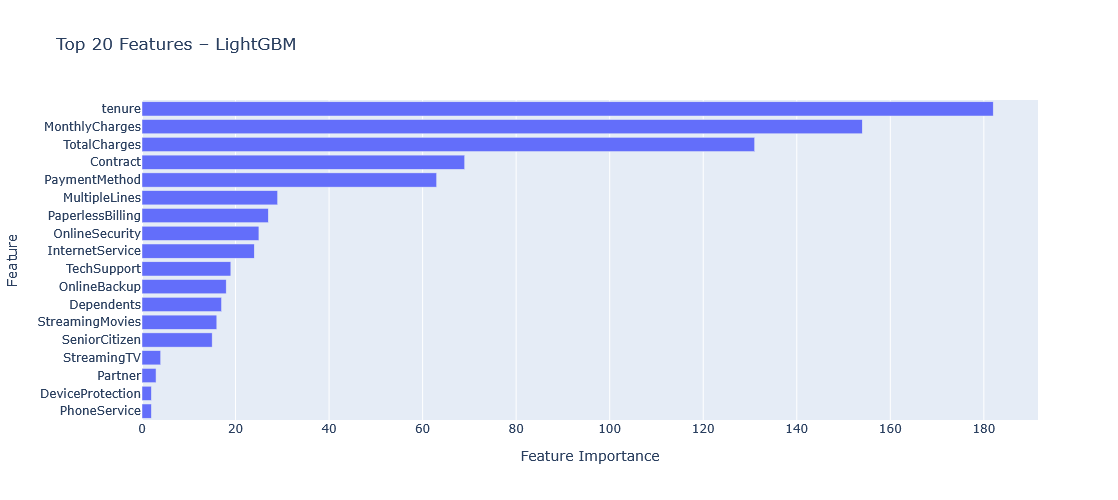

In [295]:
lgb_model = final_model.named_steps['model']
importances = lgb_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

top20 = feature_importance_df.head(20)

fig = px.bar(
    top20,
    x="Importance",
    y="Feature",
    orientation="h",
    title="Top 20 Features – LightGBM",
)

fig.update_layout(
    yaxis=dict(autorange="reversed"),  # highest importance at top
    xaxis_title="Feature Importance",
    yaxis_title="Feature",
    height=500,
    width=500
)

fig.show()


C:\Users\thede\anaconda3\Lib\site-packages\shap\explainers\_tree.py:586: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



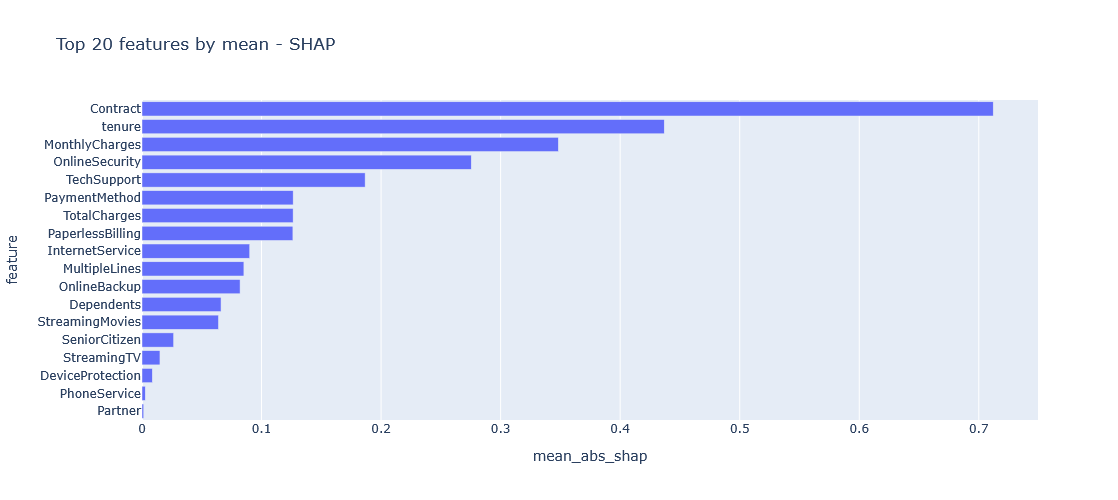

In [293]:
explainer = shap.TreeExplainer(final_model.named_steps["model"])
X_train_transformed = ct.transform(X_train)
shap_values = explainer.shap_values(X_train_transformed)
feature_names_raw = ct.get_feature_names_out()
feature_names = [name.split("__", 1)[1] for name in feature_names_raw]

if isinstance(shap_values, list):
    shap_vals = shap_values[1]
else:
    shap_vals = shap_values

mean_abs_shap = np.abs(shap_vals).mean(axis=0)

shap_df = pd.DataFrame({
    "feature": feature_names,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False)

fig = px.bar(
    shap_df.head(20),
    x="mean_abs_shap",
    y="feature",
    orientation="h",
    title="Top 20 features by mean - SHAP",
    height=500,
    width=500
)

fig.update_layout(yaxis=dict(autorange="reversed"))
fig.show()

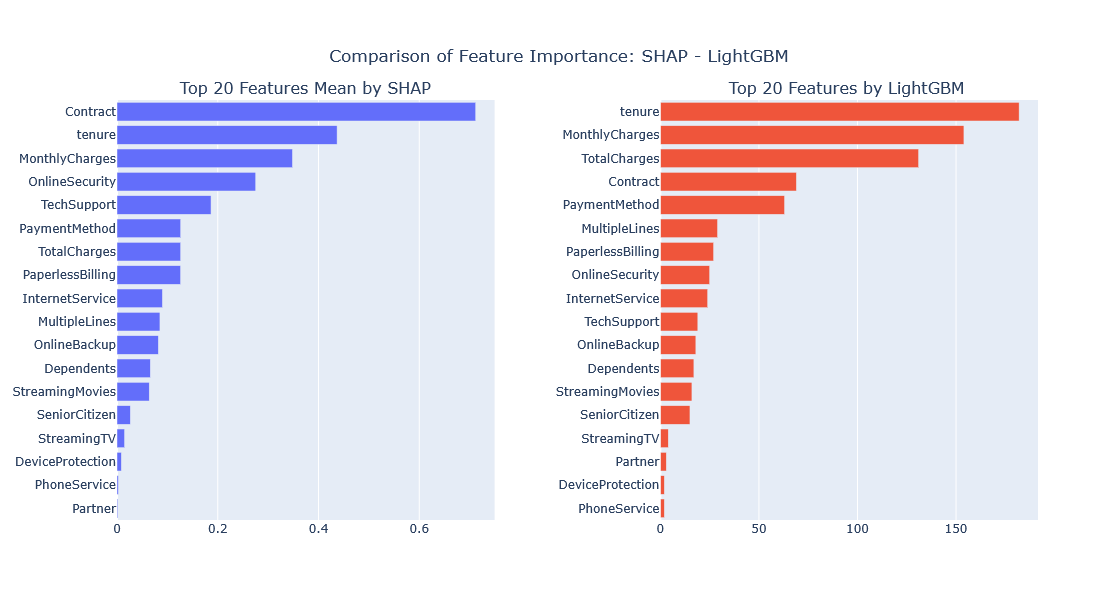

In [311]:
fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=(
        "Top 20 Features Mean by SHAP",
        "Top 20 Features by LightGBM "
    ),
    horizontal_spacing=0.18
)


fig.add_trace(
    go.Bar(
        x=shap_df.head(20)["mean_abs_shap"],
        y=shap_df.head(20)["feature"],
        orientation="h",
        name="SHAP"
    ),
    row=1,
    col=1
)


fig.add_trace(
    go.Bar(
        x=top20["Importance"],
        y=top20["Feature"],
        orientation="h",
        name="LightGBM"
    ),
    row=1,
    col=2
)


fig.update_yaxes(autorange="reversed", row=1, col=1)
fig.update_yaxes(autorange="reversed", row=1, col=2)

# Layout formatting
fig.update_layout(
    height=600,
    width=1050,
    title=dict(
        text="Comparison of Feature Importance: SHAP - LightGBM",
        x=0.5,                 
        xanchor="center",     
        yanchor="top"
    ),
    showlegend=False
)

fig.show()

In [209]:
shap_df

feature  mean_abs_shap
12          Contract       0.712054
15            tenure       0.436860
16    MonthlyCharges       0.348268
6     OnlineSecurity       0.275415
9        TechSupport       0.186650
14     PaymentMethod       0.126440
17      TotalCharges       0.126407
13  PaperlessBilling       0.126233
5    InternetService       0.090110
4      MultipleLines       0.085243
7       OnlineBackup       0.082035
2         Dependents       0.066111
11   StreamingMovies       0.063952
0      SeniorCitizen       0.026443
10       StreamingTV       0.015013
8   DeviceProtection       0.008618
3       PhoneService       0.002712
1            Partner       0.001469

In [210]:
seniors = df.sort_values('SeniorCitizen', ascending=False)
seniors.head(50)

SeniorCitizen Partner Dependents  tenure PhoneService     MultipleLines  \
6101           Yes      No         No      69          Yes               Yes   
965            Yes      No         No       8          Yes                No   
3159           Yes      No         No       3          Yes               Yes   
935            Yes     Yes         No       4          Yes               Yes   
933            Yes      No         No       4          Yes               Yes   
1781           Yes     Yes         No      60          Yes               Yes   
1782           Yes      No         No      26          Yes               Yes   
3163           Yes      No         No      39          Yes               Yes   
4382           Yes      No         No       4          Yes               Yes   
4381           Yes      No         No      49          Yes               Yes   
6266           Yes      No         No      33          Yes               Yes   
926            Yes      No         No       3          Yes               Yes   
5550           Yes      No         No      21          Yes                No   
924            Yes      No         No      22          Yes                No   
2583           Yes      No         No      57          Yes                No   
6271           Yes     Yes         No      27          Yes               Yes   
1787           Yes     Yes         No      42          Yes               Yes   
6273           Yes      No         No       2          Yes                No   
4879           Yes      No         No      46          Yes               Yes   
4875           Yes     Yes         No      48          Yes               Yes   
6257           Yes      No         No       1          Yes                No   
6255           Yes     Yes         No      69          Yes               Yes   
1770           Yes      No         No      41          Yes               Yes   
963            Yes      No         No      56          Yes               Yes   
962            Yes     Yes         No       8          Yes                No   
6238           Yes     Yes         No      54          Yes               Yes   
960            Yes     Yes         No       7           No  No phone service   
4401           Yes     Yes        Yes      46          Yes               Yes   
6244           Yes     Yes         No      54          Yes               Yes   
4396           Yes      No         No       1           No  No phone service   
1771           Yes      No         No      13          Yes                No   
1776           Yes     Yes         No      72          Yes               Yes   
950            Yes      No         No       2          Yes                No   
948            Yes      No         No      35          Yes               Yes   
947            Yes     Yes        Yes      32          Yes               Yes   
2590           Yes     Yes         No      25          Yes                No   
2589           Yes      No         No       3          Yes               Yes   
1775           Yes      No         No      65          Yes               Yes   
3154           Yes      No         No       4          Yes                No   
916            Yes      No         No      23          Yes                No   
915            Yes     Yes         No       1          Yes               Yes   
5545           Yes     Yes         No      21          Yes                No   
1809           Yes     Yes         No      32          Yes               Yes   
887            Yes      No         No      27          Yes               Yes   
886            Yes      No         No       7          Yes                No   
3194           Yes     Yes         No      43           No  No phone service   
6301           Yes      No         No      67          Yes               Yes   
881            Yes      No         No      26          Yes                No   
5527           Yes     Yes         No      72          Yes               Yes   
6305 

In [211]:
churned_senior = 965
non_churned_senior = 960

In [212]:
df.iloc[churned_senior]

SeniorCitizen                           Yes
Partner                                  No
Dependents                               No
tenure                                    8
PhoneService                            Yes
MultipleLines                            No
InternetService                 Fiber optic
OnlineSecurity                          Yes
OnlineBackup                             No
DeviceProtection                         No
TechSupport                             Yes
StreamingTV                             Yes
StreamingMovies                         Yes
Contract                     Month-to-month
PaperlessBilling                         No
PaymentMethod       Credit card (automatic)
MonthlyCharges                        100.3
TotalCharges                         832.35
Churn                                   Yes
Name: 965, dtype: object

In [213]:
df.iloc[non_churned_senior]

SeniorCitizen                             Yes
Partner                                   Yes
Dependents                                 No
tenure                                      7
PhoneService                               No
MultipleLines                No phone service
InternetService                           DSL
OnlineSecurity                            Yes
OnlineBackup                               No
DeviceProtection                           No
TechSupport                                No
StreamingTV                                No
StreamingMovies                            No
Contract                       Month-to-month
PaperlessBilling                           No
PaymentMethod       Bank transfer (automatic)
MonthlyCharges                           29.8
TotalCharges                           220.45
Churn                                      No
Name: 960, dtype: object

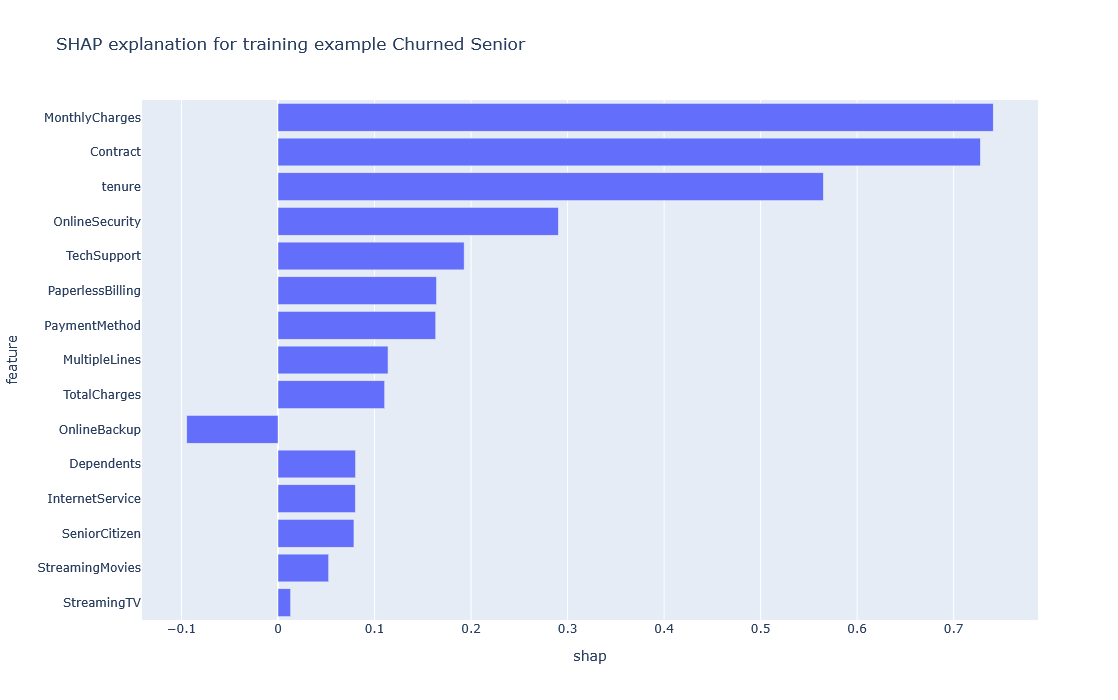

In [214]:

row_shap = shap_vals[churned_senior]
row = pd.DataFrame({
    "feature": feature_names,
    "shap": row_shap
}).sort_values("shap", key=np.abs, ascending=False).head(15)

fig_local = px.bar(
    row,
    x="shap",
    y="feature",
    orientation="h",
    title=f"SHAP explanation for training example Churned Senior",
    height = 700
)

fig_local.update_layout(yaxis=dict(autorange="reversed"))
fig_local.show()

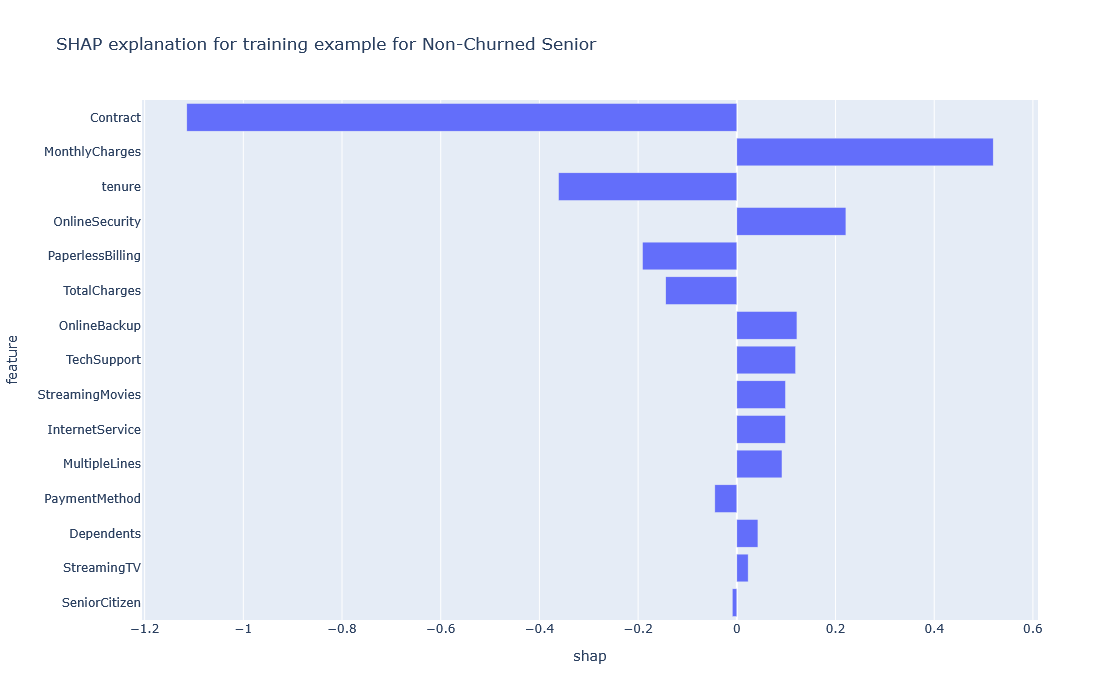

In [215]:
row_shap = shap_vals[non_churned_senior]
row = pd.DataFrame({
    "feature": feature_names,
    "shap": row_shap
}).sort_values("shap", key=np.abs, ascending=False).head(15)

fig_local = px.bar(
    row,
    x="shap",
    y="feature",
    orientation="h",
    title=f"SHAP explanation for training example for Non-Churned Senior",
    height = 700
)

fig_local.update_layout(yaxis=dict(autorange="reversed"))
fig_local.show()

In [216]:
df_vis = X_test.copy()
y_proba_test = final_model.predict_proba(X_test)[:, 1]
df_vis["y_pred_proba"] = y_proba_test
customerIDs_flat = customerIDs.ravel()
if "customerID" not in df_vis.columns:
    df_vis["customerID"] = customerIDs_flat[X_test.index]

C:\Users\thede\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



In [217]:
bins = [0, 6, 12, 24, 48, np.inf]
labels = ["0–6", "6–12", "12–24", "24–48", "48+"]

df_vis["tenure_band"] = pd.cut(df_vis["tenure"], bins=bins, labels=labels, right=False)

heat_df = (
    df_vis.groupby(["Contract", "tenure_band"])["y_pred_proba"]
    .mean()
    .reset_index()
)

heat_matrix = heat_df.pivot(
    index="Contract",
    columns="tenure_band",
    values="y_pred_proba"
)

C:\Users\thede\AppData\Local\Temp\ipykernel_20592\669500135.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [218]:
df_scores = df_vis.rename(columns={"y_pred_proba": "churn_prob"})

In [313]:
app = Dash(__name__)
fig_heat = px.imshow(
    heat_matrix.values,
    x=heat_matrix.columns,
    y=heat_matrix.index,
    color_continuous_scale="Reds",
    labels=dict(color="Avg churn probability"),
)

fig_heat.update_layout(
    title="Churn Risk by Contract Type and Tenure Band",
    xaxis_title="Tenure band (months)",
    yaxis_title="Contract type",
    coloraxis_colorbar=dict(tickformat=".0%"),
)

fig_heat.update_traces(
    hovertemplate="Contract: %{y}<br>Tenure band: %{x}<br>Avg churn prob: %{z:.2f}<extra></extra>"
)

app.layout = html.Div(
    style={"padding": "20px", "fontFamily": "Arial, sans-serif","backgroundColor": "#ffffff"},
    children=[
        html.H2("Customer Churn Dashboard", style={"marginBottom": "10px"}),

        #Heatmap section
        html.Div(
            [
                html.H4("Churn risk by contract and tenure", style={"marginBottom": "5px"}),
                html.P(
                    "This heatmap highlights where churn risk is concentrated. "
                    "Darker cells represent segments with higher predicted churn probability, ",
                    style={"maxWidth": "800px"}
                ),
                dcc.Graph(id="heatmap-contract-tenure", figure=fig_heat),
            ],
            style={"marginBottom": "40px"},
        ),

        #Top-N Customers at risk section
        html.Div(
            [
                html.H4("Top at-risk customers", style={"marginBottom": "5px"}),
                html.P(
                    "This chart ranks individual customers by predicted churn probability. "
                    "Use the slider to choose how many highest-risk customers to display, ",
                    style={"maxWidth": "800px"}
                ),

                html.Div(
                    [
                        html.Label("Number of customers to display:"),
                        dcc.Slider(
                            id="top-n-slider",
                            min=5,
                            max=50,
                            step=5,
                            value=20,
                            marks={i: str(i) for i in range(5, 55, 10)},
                        ),
                    ],
                    style={"marginBottom": "20px", "maxWidth": "400px"},
                ),

                dcc.Graph(id="top-n-bar"),
            ]
        ),
    ],
)

In [314]:
@app.callback(
    Output("top-n-bar", "figure"),
    Input("top-n-slider", "value"),
)
def update_top_n_chart(top_n):
    top_n_df = (
        df_scores[["customerID", "churn_prob", "Contract", "tenure"]]
        .sort_values("churn_prob", ascending=False)
        .head(top_n)
        .copy()
    )

    
    top_n_df["customer_label"] = top_n_df["customerID"].astype(str)

    top_n_df = top_n_df.sort_values("churn_prob", ascending=True)

    xmin = max(0.0, top_n_df["churn_prob"].min() - 0.02)

    fig = px.bar(
        top_n_df,
        x="churn_prob",
        y="customer_label",          
        orientation="h",
        labels={
            "churn_prob": "Predicted churn probability",
            "customer_label": "Customer",
        },
        title=f"Top {top_n} Customers by Predicted Churn Risk",
    )

    fig.update_traces(
        marker_line_color="white",
        marker_line_width=0.5,
    )

    fig.update_layout(
        xaxis_tickformat=".0%",
        xaxis=dict(range=[xmin, 1.0]),
        margin=dict(l=80, r=20, t=60, b=40),
        coloraxis_showscale=False,
    )


    return fig


In [317]:

if __name__ == "__main__":
    app.run(debug=True)

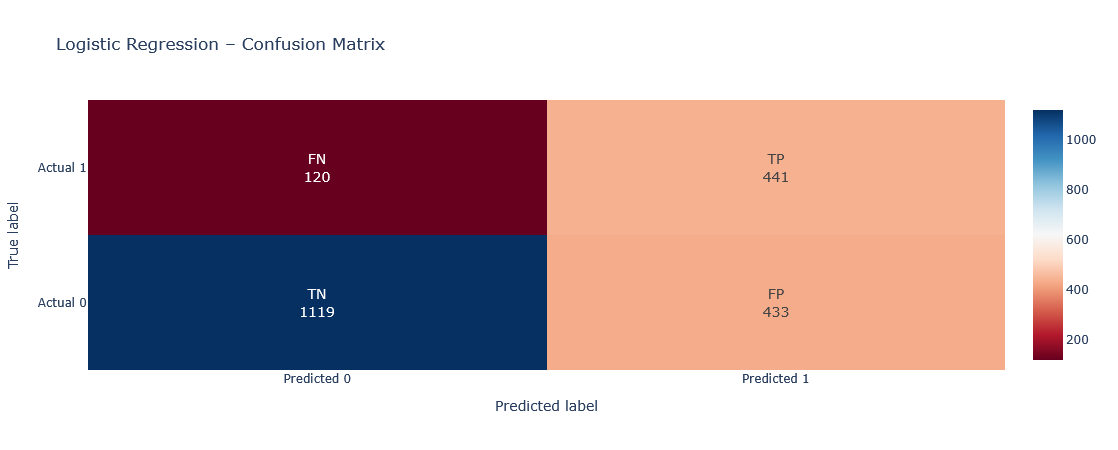

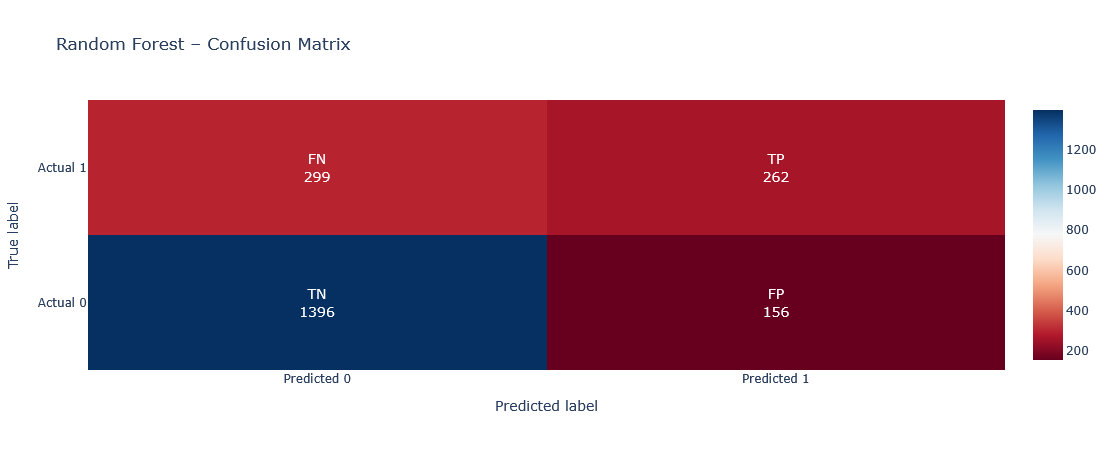

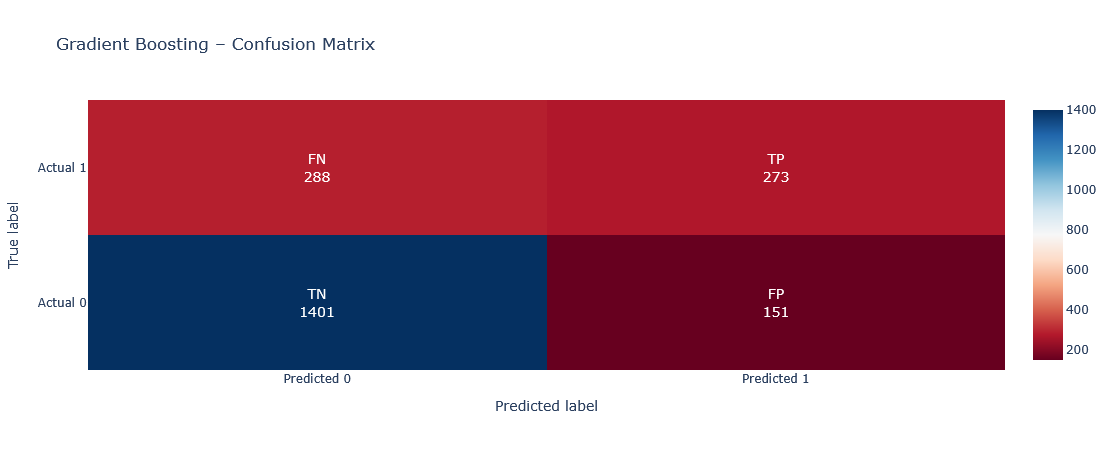

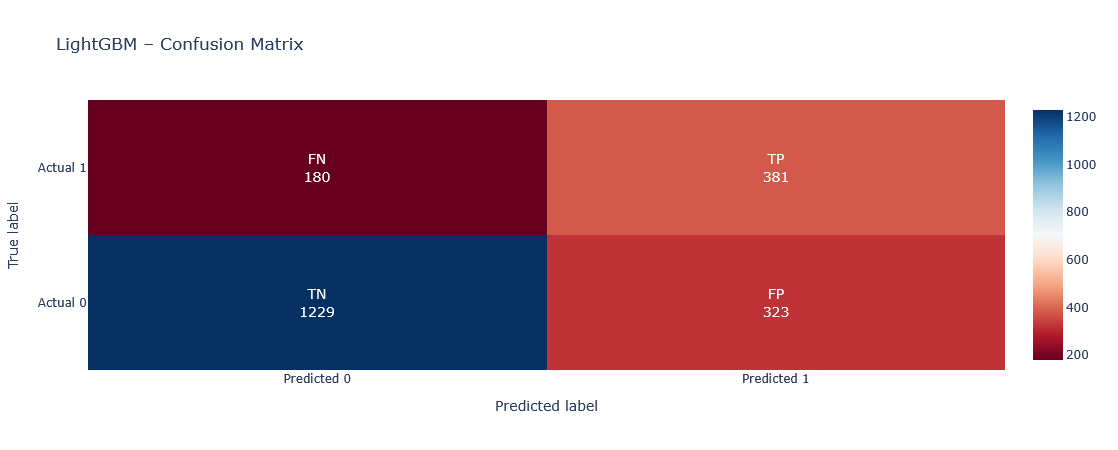

In [250]:
confusion_matrices = {
    "Logistic Regression": np.array([[1119, 433],
                                     [120,  441]]),

    "Random Forest": np.array([[1396, 156],
                               [299,  262]]),

    "Gradient Boosting": np.array([[1401, 151],
                                   [288,  273]]),

    "LightGBM": np.array([[1229, 323],
                          [180,  381]])
}

def plot_confusion_matrix_heatmap(cm, title):
    labels = np.array([["TN", "FP"], ["FN", "TP"]])
    text = np.empty_like(cm).astype(str)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text[i, j] = f"{labels[i, j]}<br>{cm[i, j]}"

    fig_cm = go.Figure(
        data=go.Heatmap(
            z=cm,
            x=["Predicted 0", "Predicted 1"],
            y=["Actual 0", "Actual 1"],
            text=text,
            texttemplate="%{text}",
            textfont={"size": 14},
            showscale=True,
            hovertemplate="%{y} / %{x}<br>Count: %{z}<extra></extra>",
            colorscale="RdBu"
        )
    )

    fig_cm.update_layout(
        title=title,
        xaxis_title="Predicted label",
        yaxis_title="True label",
        width=500,
        height=450
    )

    fig_cm.show()

for model_name, cm in confusion_matrices.items():
    plot_confusion_matrix_heatmap(cm, f"{model_name} – Confusion Matrix")

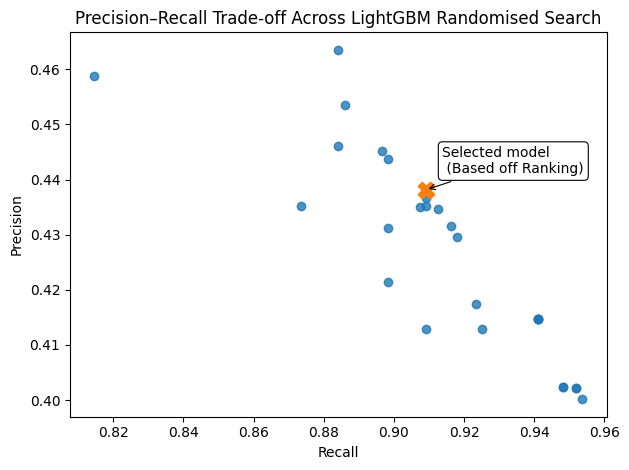

In [262]:
plt.figure()

plt.scatter(
    best_df["Recall"],
    best_df["Precision"],
    alpha=0.8
)


plt.scatter(
    best_overall_row["Recall"],
    best_overall_row["Precision"],
    s=140,
    marker="X"
)


plt.annotate(
    "Selected model\n (Based off Ranking)",
    (best_overall_row["Recall"], best_overall_row["Precision"]),
    textcoords="offset points",
    xytext=(12, 12),
    ha="left",
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.8),
    arrowprops=dict(arrowstyle="->", lw=0.8)
)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Trade-off Across LightGBM Randomised Search")
plt.tight_layout()
plt.show()